# Modeling DepMap data

In [1]:
import pandas as pd
import numpy as np
import plotnine as gg
import pymc3 as pm
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
import string
from itertools import product
from numpy.random import normal, exponential

In [2]:
import warnings

warnings.simplefilter(action="ignore", category=UserWarning)

In [3]:
gg.theme_set(gg.theme_minimal(base_family="Arial"))

In [4]:
RANDOM_SEED = 103

## Model 1. Single gene linear model with one covariate

Model the logFC of one gene in multiple cell lines using a single predictor: RNA expression.

$$
logFC \sim Normal(\mu, \sigma) \\
\mu = \alpha + \beta R \\
\alpha \sim \mathcal{N}(0, 10) \\
\beta \sim \mathcal{N}(0, 1) \\
\sigma \sim \text{HalfNormal}(5)
$$

Simulated values:

- number of cell lines: 20
- $\alpha$ = 0.5
- $\beta$ = -1
- $\sigma$ = 0.3

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


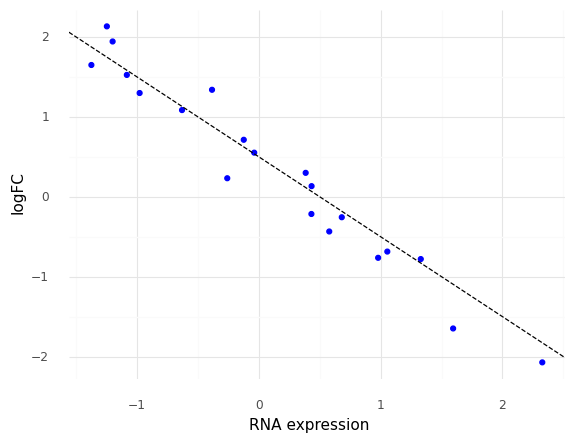

<ggplot: (8786095405999)>

In [5]:
N_CELL_LINES = 20
real_alpha = 0.5
real_beta = -1
real_sigma = 0.3

# Synthetic data
np.random.seed(RANDOM_SEED)
rna = np.random.randn(N_CELL_LINES)
logfc = real_alpha + real_beta * rna + np.random.normal(0, real_sigma, N_CELL_LINES)
data = pd.DataFrame({"rna": rna, "logfc": logfc})

(
    gg.ggplot(data, gg.aes("rna", "logfc"))
    + gg.geom_point(color="blue")
    + gg.geom_abline(slope=real_beta, intercept=real_alpha, linetype="--")
    + gg.labs(x="RNA expression", y="logFC")
)

In [6]:
with pm.Model() as model1:
    alpha = pm.Normal("alpha", 0, 10)
    beta = pm.Normal("beta", 0, 1)
    sigma = pm.HalfNormal("sigma", 5)

    mu = pm.Deterministic("mu", alpha + beta * data.rna)

    logfc = pm.Normal("logfc", mu=mu, sigma=sigma, observed=data.logfc)

    model1_prior_check = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    model1_trace = pm.sample(1000)
    model1_post_check = pm.sample_posterior_predictive(
        model1_trace, random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
100%|██████████| 4000/4000 [00:04<00:00, 886.22it/s]


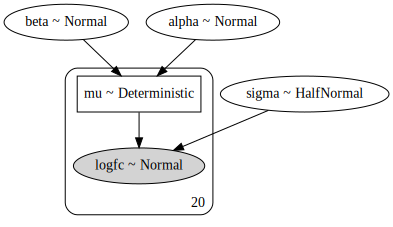

In [7]:
pm.model_to_graphviz(model1)

In [8]:
az_model1 = az.from_pymc3(
    model1_trace, posterior_predictive=model1_post_check, prior=model1_prior_check
)

In [9]:
var_names = ["alpha", "beta", "sigma"]
az.summary(az_model1, var_names=var_names)

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
alpha  0.438  0.065   0.309    0.557      0.001    0.001    3892.0  3892.0   
beta  -1.102  0.064  -1.226   -0.990      0.001    0.001    3199.0  3161.0   
sigma  0.276  0.051   0.191    0.372      0.001    0.001    2807.0  2607.0   

       ess_bulk  ess_tail  r_hat  
alpha    3918.0    2627.0    1.0  
beta     3267.0    2267.0    1.0  
sigma    3135.0    2560.0    1.0

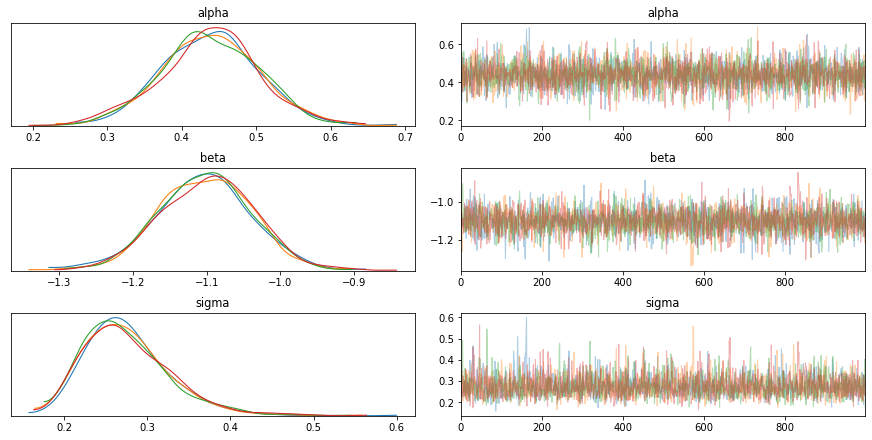

In [10]:
az.plot_trace(az_model1, var_names=var_names)
plt.show()

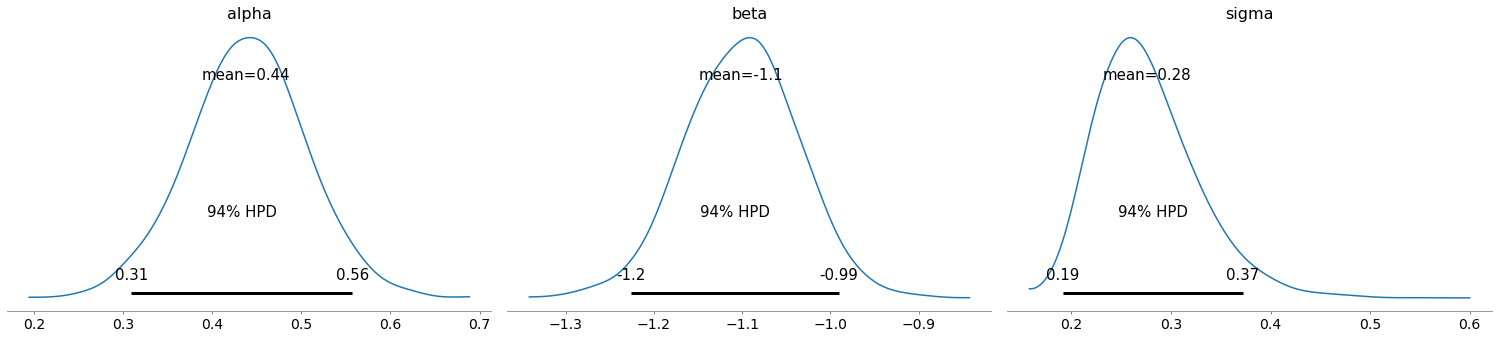

In [11]:
az.plot_posterior(az_model1, var_names=var_names)
plt.show()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


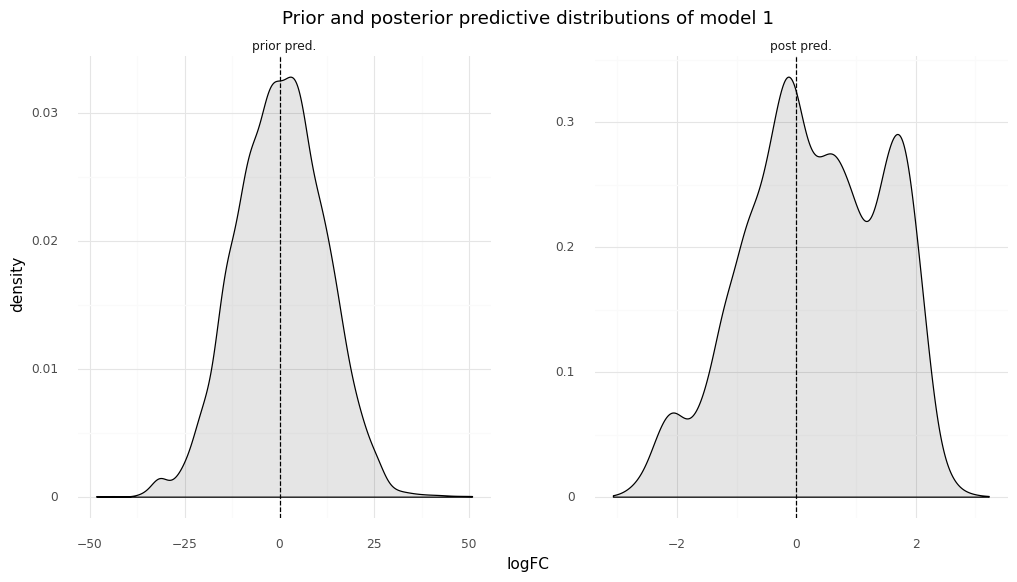

<ggplot: (8786093237462)>

In [12]:
prior_pred = (
    az_model1.prior_predictive.to_dataframe()
    .sample(frac=0.5)
    .assign(pred="prior pred.")
)
post_pred = (
    az_model1.posterior_predictive.to_dataframe()
    .sample(frac=0.2)
    .assign(pred="post pred.")
)
model1_preds = pd.concat([prior_pred, post_pred])
model1_preds["pred"] = pd.Categorical(
    model1_preds.pred, categories=["prior pred.", "post pred."]
)
(
    gg.ggplot(model1_preds, gg.aes("logfc"))
    + gg.facet_wrap("pred", nrow=1, scales="free")
    + gg.geom_density(fill="black", alpha=0.1)
    + gg.geom_vline(xintercept=0, linetype="--")
    + gg.scale_y_continuous(limits=(0, np.nan))
    + gg.labs(
        x="logFC",
        y="density",
        title="Prior and posterior predictive distributions of model 1",
    )
    + gg.theme(figure_size=[12, 6], subplots_adjust={"wspace": 0.25})
)

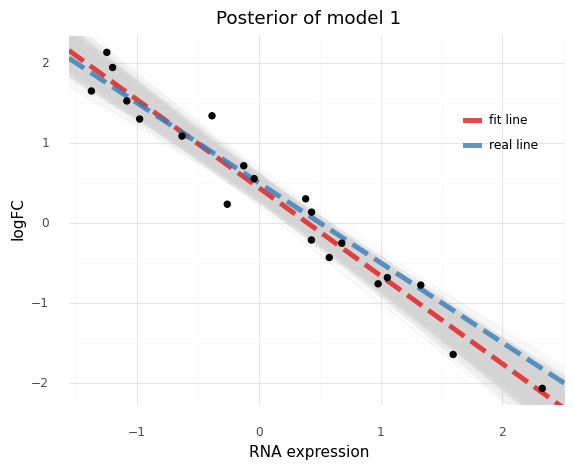

<ggplot: (8786095403783)>

In [13]:
post = az_model1.posterior.to_dataframe()

post_summary = pd.DataFrame(
    {
        "name": ["real line", "fit line"],
        "slope": [real_beta, post.mean()["beta"]],
        "intercept": [real_alpha, post.mean()["alpha"]],
    }
)

(
    gg.ggplot(post.sample(frac=0.1))
    + gg.geom_abline(
        gg.aes(slope="beta", intercept="alpha"), alpha=0.1, color="lightgrey"
    )
    + gg.geom_abline(
        gg.aes(slope="slope", intercept="intercept", color="name"),
        data=post_summary,
        size=2,
        alpha=0.8,
        linetype="--",
    )
    + gg.geom_point(gg.aes(x="rna", y="logfc"), data=data, color="black", size=2)
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.theme(legend_position=(0.8, 0.7))
    + gg.labs(x="RNA expression", y="logFC", title="Posterior of model 1", color="")
)

---

## Model 2. Multiple genes hierarchical model with one covariate

Model the logFC of multiple genes in multiple cell lines using a single predictor: RNA expression.
A hierarchcial model will be used to pool information across genes.

$$
logFC \sim Normal(\mu, \sigma) \\
\mu_g = \alpha_g + \beta_g R \\
\alpha_g \sim \mathcal{N}(\mu_\alpha, \sigma_\alpha) \\
\mu_\alpha \sim \mathcal{N}(0, 10) \qquad \sigma_\alpha \sim \text{HalfNormal}(5) \\
\beta_g \sim \mathcal{N}(\mu_\beta, \sigma_\beta) \\
\mu_\beta \sim \mathcal{N}(0, 10) \qquad \sigma_\beta \sim \text{HalfNormal}(5) \\
\sigma \sim \text{HalfNormal}(5)
$$

Simulated values:

- number of cell lines: 30
- number of genes: 5
- $\mu_\alpha$ = -1, $\sigma_\alpha$ = 1
- $\mu_\beta$ = -1, $\sigma_\beta$ = 2
- $\sigma$ = 0.3

In [14]:
np.random.seed(RANDOM_SEED)

num_cell_lines = 30
num_genes = 5

real_mu_alpha, real_sigma_alpha = -1, 1
real_mu_beta, real_sigma_beta = -1, 2
real_sigma = 0.5

real_alpha = np.random.normal(loc=real_mu_alpha, scale=real_sigma_alpha, size=num_genes)
real_beta = np.random.normal(loc=real_mu_beta, scale=real_sigma_beta, size=num_genes)

genes = ["gene" + a for a in string.ascii_uppercase[:num_genes]]
rna = np.random.randn(num_genes, num_cell_lines)

logfc = (
    real_alpha
    + real_beta * rna.T
    + np.random.normal(loc=0, scale=real_sigma, size=(rna.T.shape))
)
logfc = logfc.T

In [15]:
rna_flat = rna.flatten()
logfc_flat = logfc.flatten()
gene_idx = np.repeat(range(num_genes), num_cell_lines)

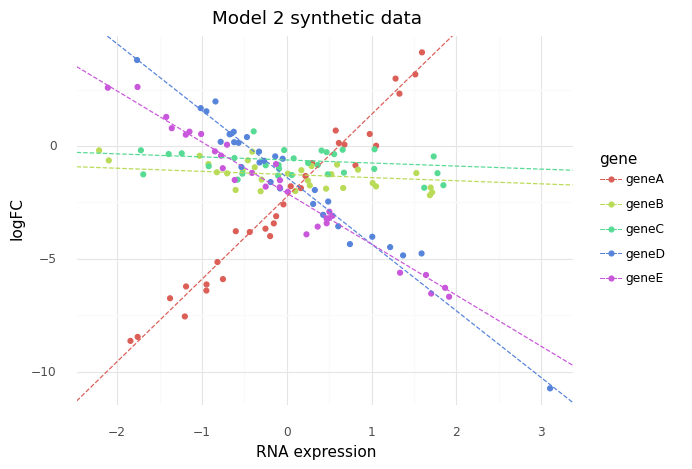

<ggplot: (8786093734882)>

In [16]:
tidy_data = pd.DataFrame(
    {"gene": [genes[i] for i in gene_idx], "rna": rna_flat, "logfc": logfc_flat}
)

tidy_real_data = pd.DataFrame({"alpha": real_alpha, "beta": real_beta, "gene": genes})


(
    gg.ggplot(tidy_data)
    + gg.geom_point(gg.aes(x="rna", y="logfc", color="gene"))
    + gg.geom_abline(
        gg.aes(slope="beta", intercept="alpha", color="gene"),
        data=tidy_real_data,
        linetype="--",
    )
    + gg.labs(
        x="RNA expression", y="logFC", color="gene", title="Model 2 synthetic data"
    )
)

In [17]:
with pm.Model() as model2:
    # Hyper-priors
    mu_alpha = pm.Normal("mu_alpha", 0, 5)
    sigma_alpha = pm.HalfNormal("sigma_alpha", 5)
    mu_beta = pm.Normal("mu_beta", 0, 2)
    sigma_beta = pm.HalfNormal("sigma_beta", 2)

    # Priors
    alpha = pm.Normal("alpha", mu_alpha, sigma_alpha, shape=num_genes)
    beta = pm.Normal("beta", mu_beta, sigma_beta, shape=num_genes)
    mu = pm.Deterministic("mu", alpha[gene_idx] + beta[gene_idx] * rna_flat)
    sigma = pm.HalfNormal("sigma", 5)

    # Likelihood
    logfc = pm.Normal("logfc", mu=mu, sigma=sigma, observed=logfc_flat)

    # Sampling
    model2_prior_check = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    model2_trace = pm.sample(2000, tune=2000, random_seed=RANDOM_SEED)
    model2_post_check = pm.sample_posterior_predictive(
        model2_trace, random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha, sigma_beta, mu_beta, sigma_alpha, mu_alpha]
Sampling 4 chains, 11 divergences: 100%|██████████| 16000/16000 [00:08<00:00, 1888.44draws/s]
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
100%|██████████| 8000/8000 [00:08<00:00, 995.51it/s] 


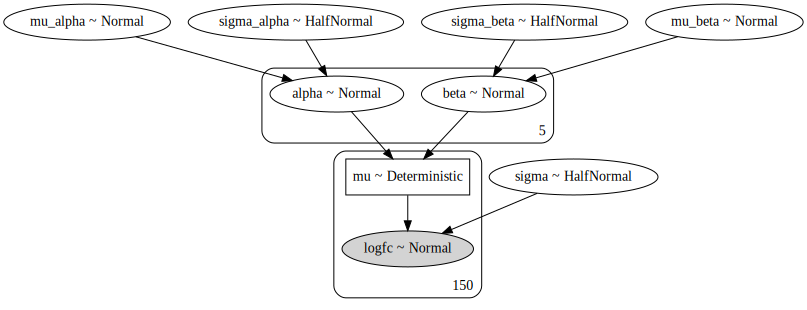

In [18]:
pm.model_to_graphviz(model2)

In [19]:
az_model2 = az.from_pymc3(
    trace=model2_trace, prior=model2_prior_check, posterior_predictive=model2_post_check
)
az.summary(az_model2, var_names=["alpha", "beta", "sigma"])

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
alpha[0] -2.414  0.100  -2.599   -2.231      0.001    0.001   14055.0   
alpha[1] -1.274  0.098  -1.461   -1.090      0.001    0.001   14085.0   
alpha[2] -0.763  0.101  -0.958   -0.575      0.001    0.001   11863.0   
alpha[3] -1.377  0.099  -1.564   -1.197      0.001    0.001   11962.0   
alpha[4] -2.148  0.098  -2.330   -1.961      0.001    0.001   12748.0   
beta[0]   3.587  0.103   3.402    3.793      0.001    0.001   13058.0   
beta[1]  -0.355  0.100  -0.543   -0.165      0.001    0.001   12660.0   
beta[2]  -0.144  0.103  -0.336    0.050      0.001    0.001   13067.0   
beta[3]  -2.837  0.103  -3.039   -2.653      0.001    0.001   13633.0   
beta[4]  -2.360  0.094  -2.534   -2.185      0.001    0.001   13713.0   
sigma     0.539  0.033   0.482    0.604      0.000    0.000   11602.0   

           ess_sd  ess_bulk  ess_tail  r_hat  
alpha[0]  14055.0   14143.0    5249.0    1.0  
alpha[1]  13538.0   14145.0    5202.0    1.0  
alpha[2]  11467.0   11840.0    5577.0    1.0  
alpha[3]  11742.0   12078.0    5465.0    1.0  
alpha[4]  12748.0   12728.0    6201.0    1.0  
beta[0]   12958.0   13027.0    5802.0    1.0  
beta[1]   10075.0   12698.0    4804.0    1.0  
beta[2]    8612.0   13061.0    6280.0    1.0  
beta[3]   13614.0   13623.0    5472.0    1.0  
beta[4]   13099.0   13662.0    5767.0    1.0  
sigma     11381.0   11762.0    5716.0    1.0

In [20]:
# Real values
pd.DataFrame({"real alpha": real_alpha, "real beta": real_beta})

real alpha  real beta
0   -2.249278   3.654438
1   -1.260331  -0.138414
2   -0.616207  -0.135368
3   -1.385461  -2.960023
4   -2.085137  -2.263930

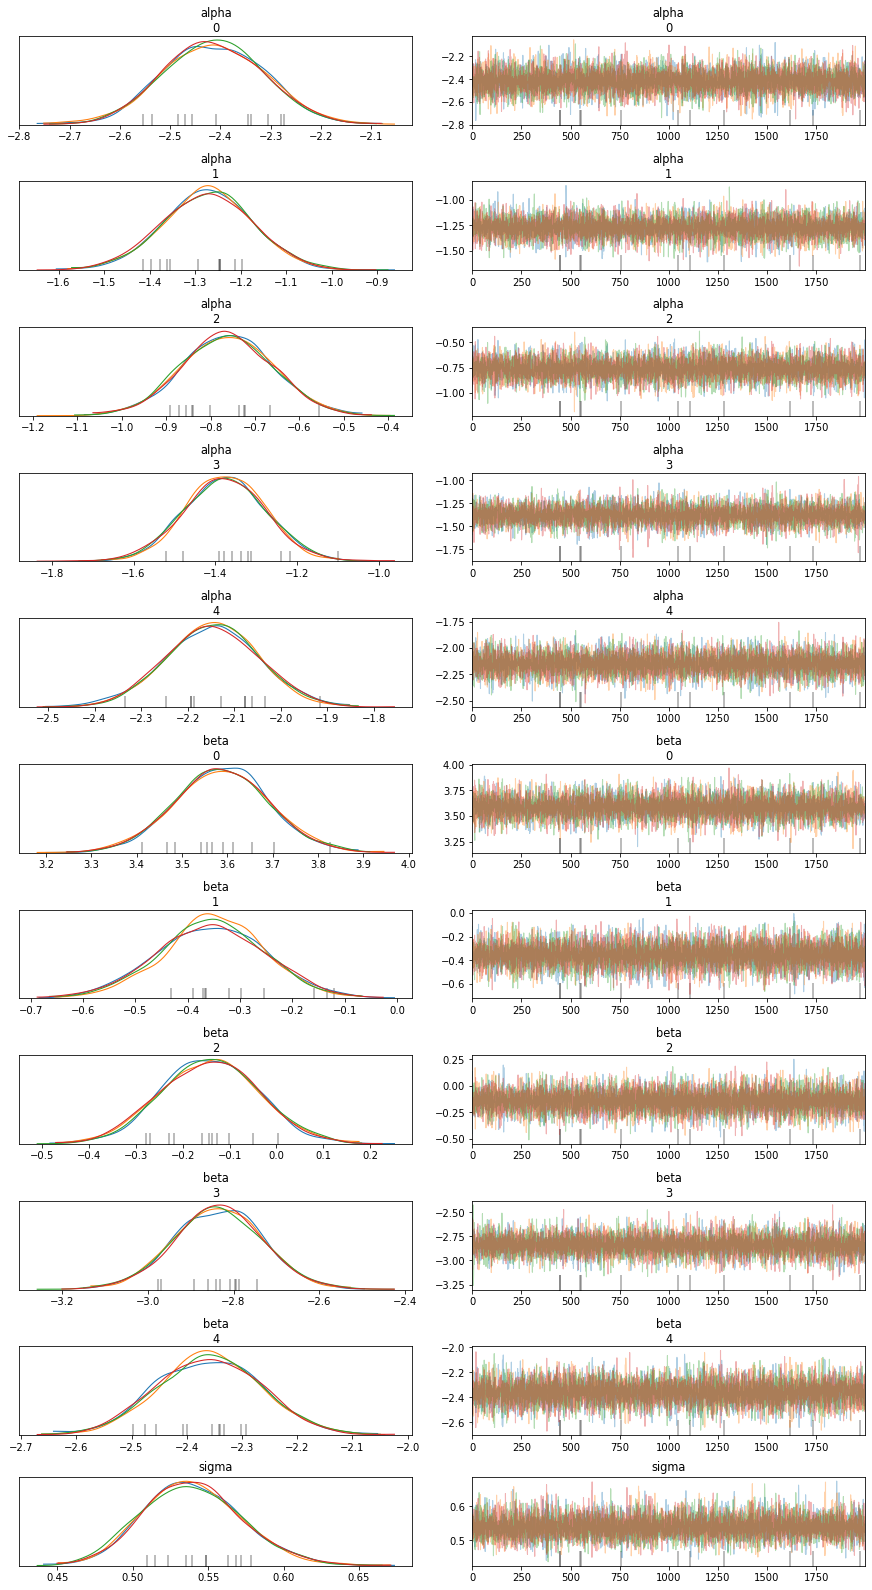

In [21]:
az.plot_trace(az_model2, var_names=var_names)
plt.show()

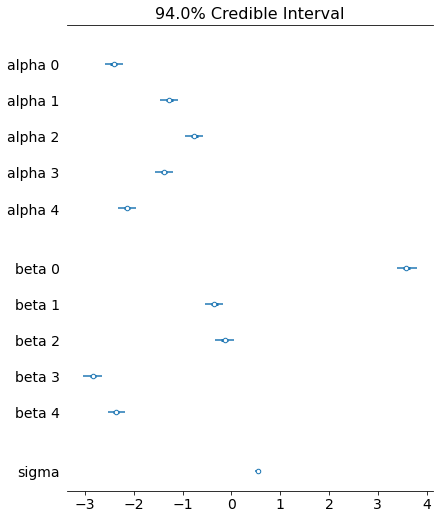

In [22]:
az.plot_forest(az_model2, var_names=var_names, combined=True)
plt.show()

In [23]:
post = (
    az_model2.posterior.to_dataframe()
    .query("alpha_dim_0 == beta_dim_0")
    .reset_index()
    .groupby(["alpha_dim_0", "beta_dim_0"])
    .apply(lambda x: x.sample(frac=0.1))
    .reset_index(drop=True)
)

In [24]:
post.head()

alpha_dim_0  beta_dim_0  chain  draw  mu_dim_0  mu_alpha   mu_beta  \
0            0           0      0  1848        13 -1.239189  0.580714   
1            0           0      1   416        68 -1.567604  1.725339   
2            0           0      1   749        55 -2.384778 -0.207552   
3            0           0      2   702        80 -1.510693 -2.066652   
4            0           0      2  1510       143 -3.255299 -0.669700   

      alpha      beta  sigma_alpha  sigma_beta        mu     sigma  
0 -2.594805  3.575071     0.742496    2.212606  2.826284  0.581841  
1 -2.552960  3.677716     0.960669    2.135674 -0.726718  0.557574  
2 -2.495805  3.767642     2.673232    1.817443 -2.020357  0.541390  
3 -2.600381  3.722385     0.682259    3.661321 -0.915152  0.501096  
4 -2.523524  3.475155     1.643196    3.595742  0.262516  0.503061

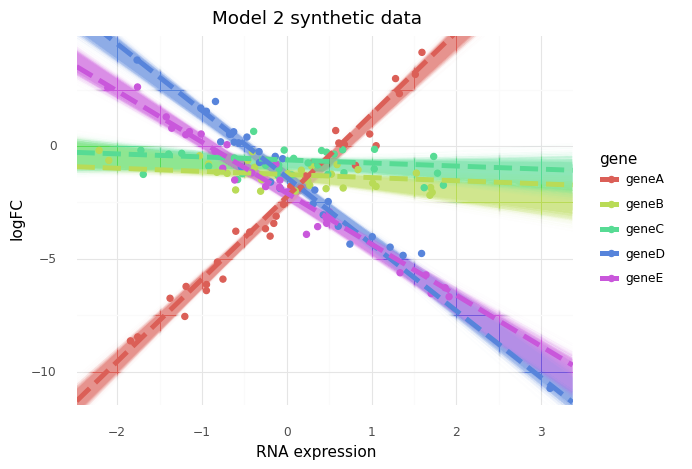

<ggplot: (8786084724721)>

In [25]:
post["gene"] = [genes[i] for i in post.alpha_dim_0]

(
    gg.ggplot(post)
    + gg.geom_abline(gg.aes(slope="beta", intercept="alpha", color="gene"), alpha=0.01)
    + gg.geom_point(gg.aes(x="rna", y="logfc", color="gene"), data=tidy_data, size=2)
    + gg.geom_abline(
        gg.aes(slope="beta", intercept="alpha", color="gene"),
        data=tidy_real_data,
        linetype="--",
        size=2,
    )
    + gg.labs(
        x="RNA expression", y="logFC", color="gene", title="Model 2 synthetic data"
    )
)

---

## Model 3. Multiple logFC readings per gene per cell line and only one RNA expression reading

Model the logFC of multiple genes in multiple cell lines using a single predictor: RNA expression.
There are multiple logFC readings per gene per cell line, but only one RNA expression reading.
(For now) there is only one varying effect for gene.

$
logFC_g \sim \mathcal{N}(\mu_g, \sigma) \\
\quad \mu_g = \alpha_g \\
\qquad \alpha_g \sim \mathcal{N}(\mu_{\alpha_g}, \sigma_{\alpha_g}) \\
\qquad \quad \mu_{\alpha_g} = \gamma_g + \delta_g R \\
\qquad \qquad \gamma_g \sim \mathcal{N}(\mu_\gamma, \sigma_\gamma) \\
\qquad \qquad \quad \mu_\gamma \sim \mathcal{N}(0,5) \quad \sigma_\gamma \sim \text{Exp}(1) \\
\qquad \qquad \delta_g \sim \mathcal{N}(\mu_\delta, \sigma_\delta) \\
\qquad \qquad \quad \mu_\delta \sim \mathcal{N}(0,5) \quad \sigma_\delta \sim \text{Exp}(1) \\
\qquad \quad \sigma_{\alpha_g} \sim \text{Exp}(\sigma_g) \\
\qquad \qquad \sigma_g \sim \text{Exp}(1) \\
\quad \sigma \sim \text{Exp}(1)
$

Simulated real values:

- number of cell lines: 30
- number of logFC data points per gene per cell line: 3
- number of genes: 5
- $\mu_\gamma = -1$
- $\sigma_\gamma = 0.4$
- $\mu_\delta = 0$
- $\sigma_\delta = 1$
- $\sigma_g = 0.4$
- $\sigma = 0.3$

In [26]:
np.random.seed(RANDOM_SEED)

# Synthetic data parmeters
num_cell_lines = 20
num_logfc_datum = 3
num_genes = 5

# Real hyper-parameter values
real_mu_gamma = -1
real_sigma_gamma = 0.4
real_mu_delta = 0
real_sigma_delta = 1
real_sigma_g = 0.4
real_sigma = 0.3


genes = ["gene" + a for a in string.ascii_uppercase[:num_genes]]
gene_idx = list(range(num_genes))

cell_lines = ["cell" + a for a in string.ascii_uppercase[:num_cell_lines]]
cell_line_idx = list(range(num_cell_lines))

# RNA expression data (scaled within each gene)
rna = np.random.normal(loc=0, scale=1, size=(num_genes, num_cell_lines))
rna_data = pd.DataFrame(list(product(genes, cell_lines)), columns=["gene", "cell_line"])
rna_data["rna"] = rna.flatten()

for c in ["gene", "cell_line"]:
    rna_data[c] = pd.Categorical(rna_data[c])


real_gamma_g = np.random.normal(real_mu_gamma, real_sigma_gamma, (num_genes, 1))
real_delta_g = np.random.normal(real_mu_delta, real_sigma_delta, (num_genes, 1))
real_mu_alpha = (real_gamma_g + rna * real_delta_g).mean(axis=1)
real_sigma_alpha = np.random.exponential(real_sigma_g, num_genes)

real_alpha_g = np.random.normal(real_mu_alpha, real_sigma_alpha)
real_mu_g = real_alpha_g

ko_idx = list(range(num_logfc_datum))
logfc_data = pd.DataFrame(
    list(product(ko_idx, genes, cell_lines)), columns=["ko_idx", "gene", "cell_line"]
)

for c in ["gene", "cell_line"]:
    logfc_data[c] = pd.Categorical(logfc_data[c])


logfc_data["logfc"] = np.nan
for i in range(len(logfc_data)):
    g = logfc_data["gene"].cat.codes[i]
    logfc_data.loc[i, "logfc"] = np.random.normal(real_mu_g[g], real_sigma)

logfc_data

ko_idx   gene cell_line     logfc
0         0  geneA     cellA -1.475160
1         0  geneA     cellB -1.574389
2         0  geneA     cellC -1.413401
3         0  geneA     cellD -1.057404
4         0  geneA     cellE -1.570743
..      ...    ...       ...       ...
295       2  geneE     cellP  0.758133
296       2  geneE     cellQ  0.352038
297       2  geneE     cellR  0.583303
298       2  geneE     cellS  0.818320
299       2  geneE     cellT  0.686769

[300 rows x 4 columns]

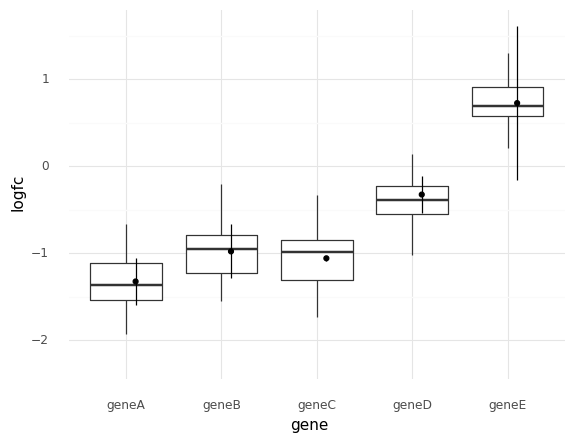

<ggplot: (8786076979652)>

In [27]:
known_logfc_values_df = pd.DataFrame(
    {"gene": genes, "logfc": real_alpha_g, "sd": real_sigma_alpha}
)
known_logfc_values_df["lower_err"] = (
    known_logfc_values_df["logfc"] - known_logfc_values_df["sd"]
)
known_logfc_values_df["upper_err"] = (
    known_logfc_values_df["logfc"] + known_logfc_values_df["sd"]
)

pos = gg.position_nudge(x=0.1)

(
    gg.ggplot(logfc_data, gg.aes(x="gene", y="logfc"))
    + gg.geom_boxplot(outlier_color="")
    + gg.geom_linerange(
        gg.aes(ymin="lower_err", ymax="upper_err"),
        data=known_logfc_values_df,
        position=pos,
    )
    + gg.geom_point(data=known_logfc_values_df, position=pos)
)

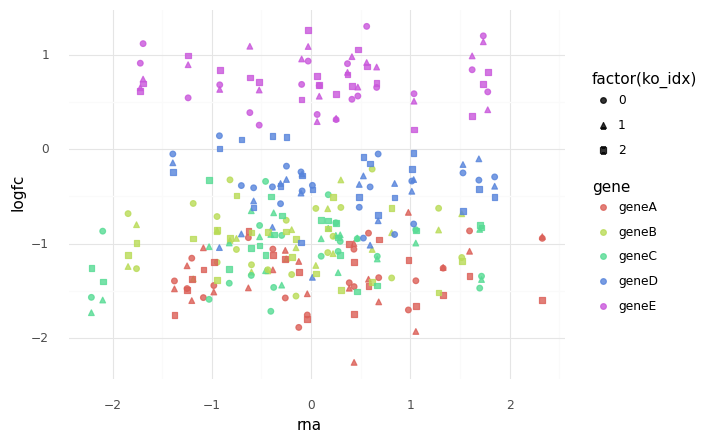

<ggplot: (8786093441410)>

In [28]:
merged_data = pd.merge(logfc_data, rna_data, how="inner", on=["gene", "cell_line"])

(
    gg.ggplot(merged_data, gg.aes(x="rna", y="logfc", color="gene"))
    + gg.geom_point(gg.aes(shape="factor(ko_idx)"), alpha=0.8, size=1.8)
)

**Conclusion**  
This was an incorrect understanding of how to use a predictor variable in a higher level of the model.
Though it is not the right model the purposes of this project, I'll leave it here as an example.

---

## Model 4. Multiple genes and multiple cell lines hierarchical model with one covariate

Model the logFC of multiple genes in multiple cell lines using a single predictor: RNA expression.
A hierarchcial model will be used to pool information across genes and cell lines.
Also, to better mimic real data, I have added in the fact that there are multiple measures of logFC for each gene, but only one measure for RNA expression.

$
logFC_{g,c} \sim Normal(\mu_{g,c}, \sigma) \\
\quad \mu_g = \alpha_g + \gamma_c + \beta_g R \\
\qquad \alpha_g \sim \mathcal{N}(\mu_\alpha, \sigma_\alpha) \\
\qquad \quad \mu_\alpha \sim \mathcal{N}(0, 5) \quad \sigma_\alpha \sim \text{Exp}(1) \\
\qquad \gamma_c \sim \mathcal{N}(\mu_\gamma, \sigma_\gamma) \\
\qquad \quad \mu_\gamma \sim \mathcal{N}(0, 5) \quad \sigma_\gamma \sim \text{Exp}(1) \\
\qquad \beta_g \sim \mathcal{N}(\mu_\beta, \sigma_\beta) \\
\qquad \quad \mu_\beta \sim \mathcal{N}(0, 2) \quad \sigma_\beta \sim \text{Exp}(1) \\
\quad \sigma \sim \text{Exp}(1)
$


Simulated values:

- number of cell lines: 20
- number of genes: 5
- number of repeated measures: 3
- $\mu_\alpha = -1$, $\sigma_\alpha = 1$
- $\mu_\gamma = 0$, $\sigma_\gamma = 3$
- $\mu_\beta = -1$, $\sigma_\beta = 2$
- $\sigma = 0.3$

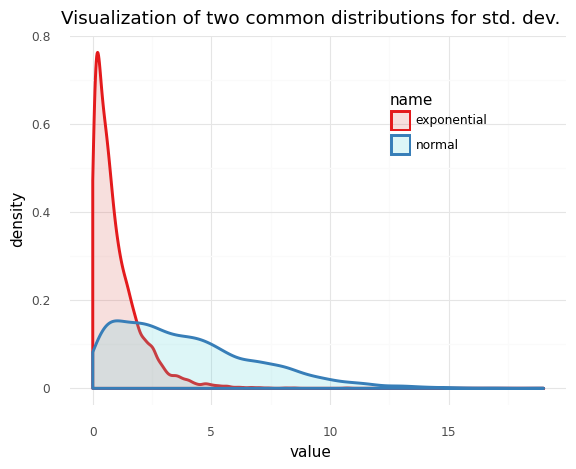

<ggplot: (8786076989669)>

In [29]:
N = 5000
np.random.seed(0)
sigma_dists = pd.DataFrame(
    {
        "name": np.repeat(["normal", "exponential"], N),
        "value": np.concatenate(
            [np.abs(np.random.normal(0, 5, N)), np.random.exponential(1, N)]
        ).flatten(),
    }
)

(
    gg.ggplot(sigma_dists, gg.aes("value"))
    + gg.geom_density(gg.aes(color="name", fill="name"), alpha=0.2, size=1.2)
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.theme(legend_position=(0.7, 0.7))
    + gg.labs(title="Visualization of two common distributions for std. dev.")
)

In [30]:
np.random.seed(RANDOM_SEED)

# Real data parameters.
num_genes = 5
num_cell_lines = 20
num_logfc_datum = 3

# Real model values.
real_mu_alpha, real_sigma_alpha = -1, 1
real_mu_gamma, real_sigma_gamma = 0, 3
real_mu_beta, real_sigma_beta = -1, 2
real_sigma = 0.3

# Sample from real distributions for the rest of the model parameters.
real_alpha_g = np.random.normal(real_mu_alpha, real_sigma_alpha, num_genes)
real_gamma_c = np.random.normal(real_mu_gamma, real_sigma_gamma, num_cell_lines)
real_beta_g = np.random.normal(real_mu_beta, real_sigma_beta, num_genes)

rna_data = pd.DataFrame(list(product(genes, cell_lines)), columns=["gene", "cell_line"])

# RNA data (scaled by gene).
rna_data["rna"] = np.random.normal(0, 1, len(rna_data))

for c in ["gene", "cell_line"]:
    rna_data[c] = pd.Categorical(rna_data[c])

logfc_data = []
for i in range(num_logfc_datum):
    x = rna_data.copy()
    x["sgrna_idx"] = i
    logfc_data.append(x)

logfc_data = pd.concat(logfc_data).reset_index(drop=True)

logfc_data["logfc"] = np.nan
for i in range(len(logfc_data)):
    gene_i = logfc_data["gene"].cat.codes[i]
    cell_line_i = logfc_data["cell_line"].cat.codes[i]
    mu = (
        real_alpha_g[gene_i]
        + real_gamma_c[cell_line_i]
        + real_beta_g[gene_i] * logfc_data.loc[i, "rna"]
    )
    logfc_data.loc[i, "logfc"] = np.random.normal(mu, real_sigma)

logfc_data

gene cell_line       rna  sgrna_idx     logfc
0    geneA     cellA -1.187443          0  7.516370
1    geneA     cellB  0.299138          0 -1.184598
2    geneA     cellC -0.947764          0  1.945419
3    geneA     cellD -1.843382          0 -0.861100
4    geneA     cellE  0.810589          0 -6.491923
..     ...       ...       ...        ...       ...
295  geneE     cellP  1.219362          2  0.194254
296  geneE     cellQ -0.840481          2 -5.967522
297  geneE     cellR  0.607882          2 -0.719954
298  geneE     cellS  0.429605          2  1.885927
299  geneE     cellT -1.014537          2 -1.022285

[300 rows x 5 columns]

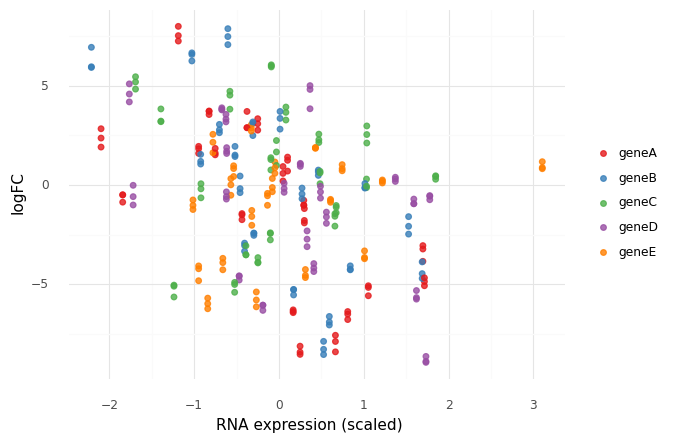

<ggplot: (8786089856458)>

In [31]:
(
    gg.ggplot(logfc_data, gg.aes(x="rna", y="logfc", color="gene"))
    + gg.geom_point(size=1.8, alpha=0.8)
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.labs(x="RNA expression (scaled)", y="logFC", color="")
)

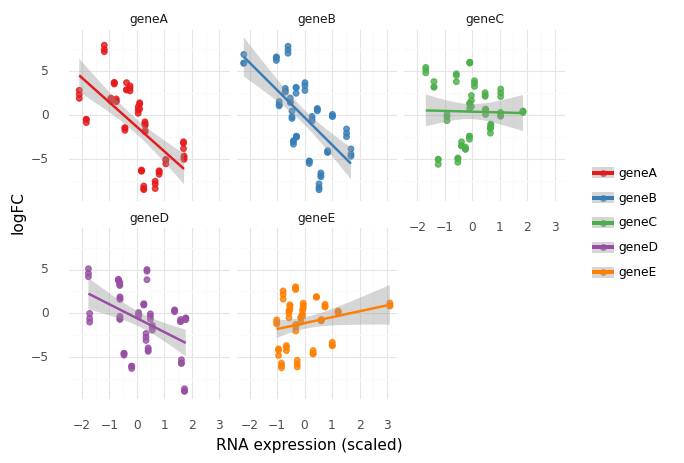

<ggplot: (8786089849101)>

In [32]:
(
    gg.ggplot(logfc_data, gg.aes(x="rna", y="logfc", color="gene"))
    + gg.facet_wrap("gene", nrow=2)
    + gg.geom_point(size=1.8, alpha=0.8)
    + gg.geom_smooth(method="lm")
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.labs(x="RNA expression (scaled)", y="logFC", color="")
)

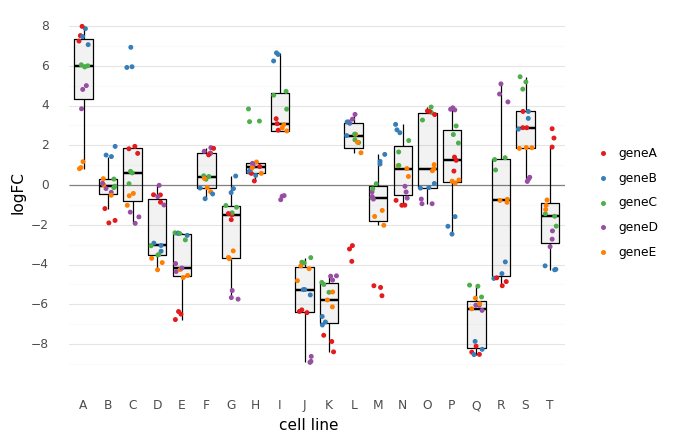

<ggplot: (8786076985546)>

In [33]:
(
    gg.ggplot(logfc_data, gg.aes(x="cell_line", y="logfc"))
    + gg.geom_hline(yintercept=0, color="gray")
    + gg.geom_boxplot(color="black", fill="black", alpha=0.05, outlier_color="")
    + gg.geom_jitter(gg.aes(color="gene"), width=0.3, size=1)
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.scale_x_discrete(labels=[a.replace("cell", "") for a in cell_lines])
    + gg.scale_y_continuous(breaks=range(-16, 16, 2))
    + gg.theme(panel_grid_major_x=gg.element_blank())
    + gg.labs(x="cell line", y="logFC", color="")
)

In [34]:
gene_idx = logfc_data["gene"].cat.codes.to_list()
cell_line_idx = logfc_data["cell_line"].cat.codes.to_list()

with pm.Model() as model4:
    # Hyper-priors
    mu_alpha = pm.Normal("mu_alpha", 0, 2)
    sigma_alpha = pm.Exponential("sigma_alpha", 1)
    mu_gamma = pm.Normal("mu_gamma", 0, 2)
    sigma_gamma = pm.Exponential("sigma_gamma", 1)
    mu_beta = pm.Normal("mu_beta", 0, 1)
    sigma_beta = pm.Exponential("sigma_beta", 1)

    # Priors
    alpha_g = pm.Normal("alpha_g", mu_alpha, sigma_alpha, shape=num_genes)
    gamma_c = pm.Normal("gamma_c", mu_gamma, sigma_gamma, shape=num_cell_lines)
    beta_g = pm.Normal("beta_g", mu_beta, sigma_beta, shape=num_genes)
    mu_gc = pm.Deterministic(
        "mu_gc",
        alpha_g[gene_idx] + gamma_c[cell_line_idx] + beta_g[gene_idx] * logfc_data.rna,
    )
    sigma = pm.Exponential("sigma", 1)

    # Likelihood
    logfc = pm.Normal("logfc", mu=mu_gc, sigma=sigma, observed=logfc_data.logfc)

    # Sampling
    model4_prior_check = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    model4_trace = pm.sample(2000, tune=2000, random_seed=RANDOM_SEED)
    model4_post_check = pm.sample_posterior_predictive(
        model4_trace, random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_g, gamma_c, alpha_g, sigma_beta, mu_beta, sigma_gamma, mu_gamma, sigma_alpha, mu_alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [02:46<00:00, 96.21draws/s] 
The number of effective samples is smaller than 10% for some parameters.
100%|██████████| 8000/8000 [00:07<00:00, 1003.90it/s]


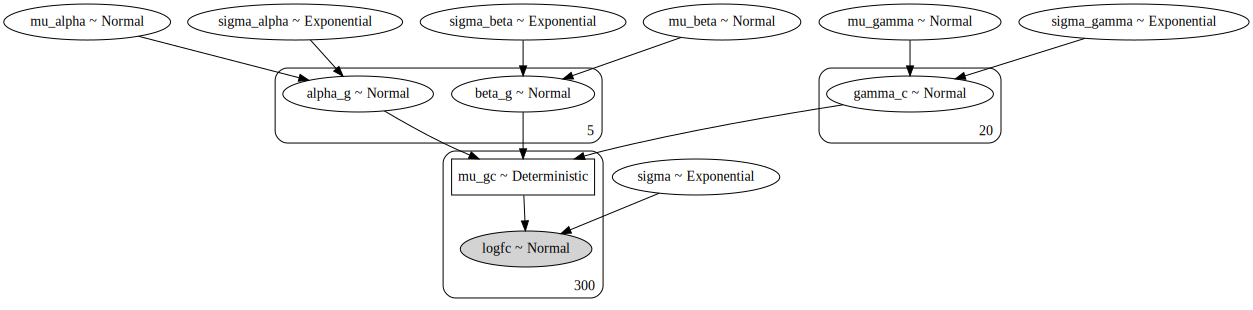

In [35]:
pm.model_to_graphviz(model4)

In [36]:
az_model4 = az.from_pymc3(
    trace=model4_trace,
    prior=model4_prior_check,
    posterior_predictive=model4_post_check,
    model=model4,
)

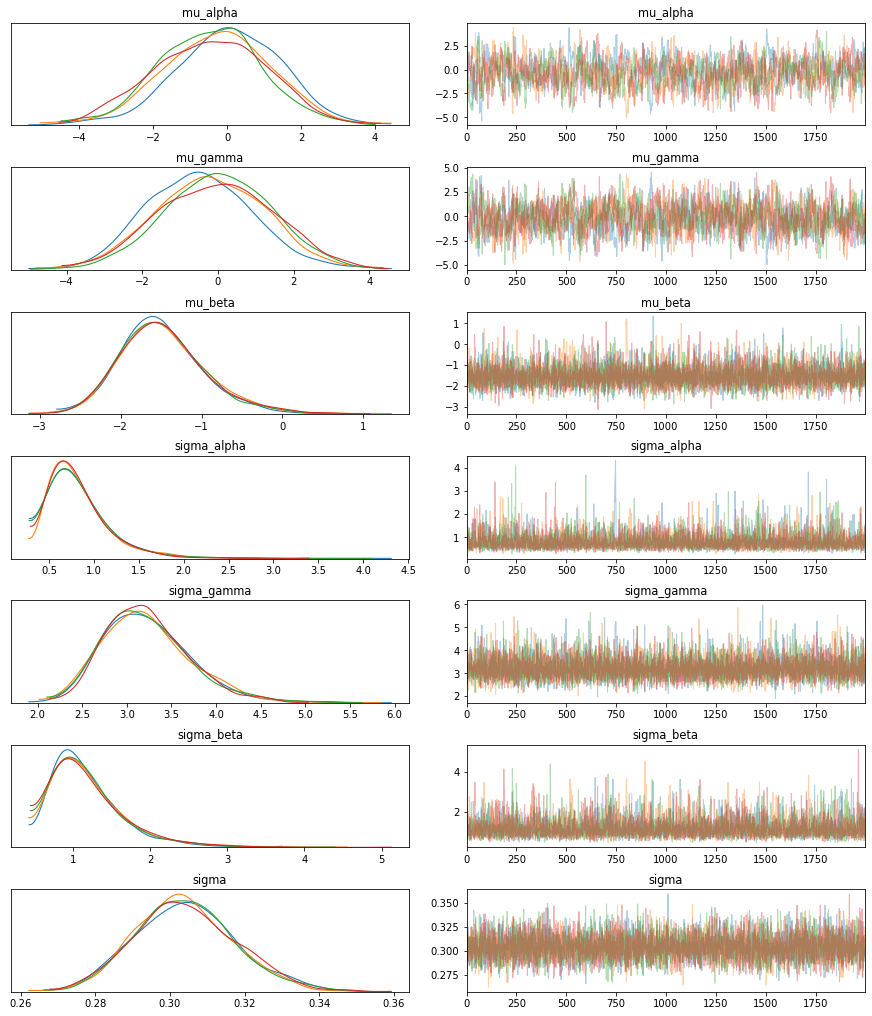

In [37]:
var_names1 = ["mu_" + a for a in ["alpha", "gamma", "beta"]]
var_names2 = ["sigma_" + a for a in ["alpha", "gamma", "beta"]]
az.plot_trace(az_model4, var_names=var_names1 + var_names2 + ["sigma"])
plt.show()

In [38]:
s = az.summary(az_model4, var_names=var_names1 + var_names2)
s["real_values"] = [
    real_mu_alpha,
    real_mu_gamma,
    real_mu_beta,
    real_sigma_alpha,
    real_sigma_gamma,
    real_sigma_beta,
]
s

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
mu_alpha    -0.310  1.459  -3.050    2.430      0.057    0.041     644.0   
mu_gamma    -0.193  1.457  -2.900    2.499      0.054    0.038     735.0   
mu_beta     -1.486  0.524  -2.436   -0.476      0.008    0.005    4738.0   
sigma_alpha  0.830  0.360   0.365    1.476      0.006    0.005    3596.0   
sigma_gamma  3.221  0.486   2.362    4.116      0.006    0.004    7178.0   
sigma_beta   1.188  0.483   0.474    2.047      0.008    0.006    3902.0   

             ess_sd  ess_bulk  ess_tail  r_hat  real_values  
mu_alpha      644.0     645.0    1228.0   1.01           -1  
mu_gamma      735.0     737.0    1404.0   1.01            0  
mu_beta      4738.0    5485.0    3922.0   1.00           -1  
sigma_alpha  2978.0    5136.0    3988.0   1.00            1  
sigma_gamma  6662.0    7897.0    5216.0   1.00            3  
sigma_beta   3678.0    5037.0    4419.0   1.00            2

I believe that the $\alpha_g$ values were poorly estimated because they do not add much information to the model.
The other parameters fit well, but these have very wide posterior distributions.

In [39]:
az.summary(az_model4, var_names=["alpha_g"]).assign(real_values=real_alpha_g)

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
alpha_g[0] -1.113  1.461  -3.996    1.479       0.06    0.043     589.0   
alpha_g[1] -0.053  1.462  -2.870    2.616       0.06    0.043     591.0   
alpha_g[2]  0.574  1.463  -2.269    3.223       0.06    0.043     589.0   
alpha_g[3] -0.219  1.462  -3.132    2.346       0.06    0.043     590.0   
alpha_g[4] -0.816  1.462  -3.770    1.722       0.06    0.043     589.0   

            ess_sd  ess_bulk  ess_tail  r_hat  real_values  
alpha_g[0]   589.0     589.0    1083.0   1.01    -2.249278  
alpha_g[1]   591.0     591.0    1132.0   1.02    -1.260331  
alpha_g[2]   589.0     589.0    1101.0   1.02    -0.616207  
alpha_g[3]   590.0     590.0    1070.0   1.02    -1.385461  
alpha_g[4]   589.0     589.0    1136.0   1.02    -2.085137

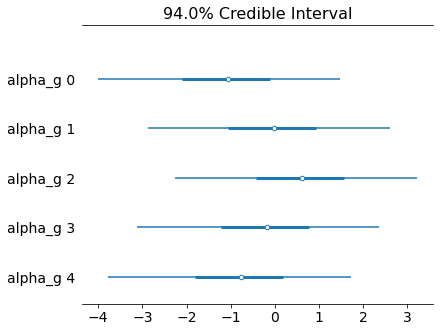

In [40]:
az.plot_forest(az_model4, var_names=["alpha_g"], combined=True)
plt.show()

In [41]:
az.summary(az_model4, var_names=["beta_g"]).assign(real_values=real_beta_g)

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
beta_g[0] -2.552  0.043  -2.632   -2.470      0.000      0.0    7998.0   
beta_g[1] -2.888  0.049  -2.979   -2.794      0.001      0.0    7516.0   
beta_g[2] -0.564  0.050  -0.657   -0.471      0.001      0.0    8176.0   
beta_g[3] -2.239  0.043  -2.317   -2.160      0.000      0.0    7748.0   
beta_g[4] -1.283  0.045  -1.368   -1.198      0.001      0.0    7433.0   

           ess_sd  ess_bulk  ess_tail  r_hat  real_values  
beta_g[0]  7993.0    7987.0    5499.0    1.0    -2.634413  
beta_g[1]  7515.0    7537.0    5781.0    1.0    -2.892255  
beta_g[2]  8169.0    8169.0    6117.0    1.0    -0.558722  
beta_g[3]  7748.0    7773.0    5935.0    1.0    -2.201467  
beta_g[4]  7433.0    7416.0    5317.0    1.0    -1.305132

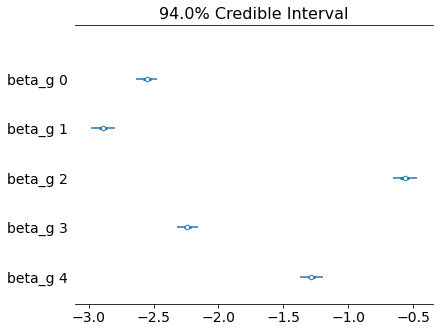

In [42]:
az.plot_forest(az_model4, var_names=["beta_g"], combined=True)
plt.show()

In [43]:
az.summary(az_model4, var_names=["gamma_c"]).assign(real_values=real_gamma_c)

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
gamma_c[0]   5.628  1.463   3.067    8.555      0.060    0.043     590.0   
gamma_c[1]   0.141  1.464  -2.543    2.935      0.060    0.043     591.0   
gamma_c[2]   0.077  1.466  -2.584    2.907      0.061    0.043     584.0   
gamma_c[3]  -4.141  1.466  -6.870   -1.382      0.060    0.043     589.0   
gamma_c[4]  -3.214  1.463  -5.807   -0.338      0.060    0.043     590.0   
gamma_c[5]   0.672  1.466  -1.941    3.545      0.060    0.043     592.0   
gamma_c[6]  -1.480  1.465  -4.277    1.229      0.060    0.043     594.0   
gamma_c[7]   1.860  1.464  -0.785    4.713      0.060    0.043     589.0   
gamma_c[8]   3.481  1.464   0.853    6.345      0.060    0.043     591.0   
gamma_c[9]  -4.720  1.463  -7.315   -1.839      0.060    0.043     589.0   
gamma_c[10] -5.384  1.463  -7.936   -2.472      0.060    0.043     589.0   
gamma_c[11]  2.053  1.464  -0.544    4.938      0.060    0.043     593.0   
gamma_c[12] -1.418  1.463  -3.981    1.498      0.060    0.043     586.0   
gamma_c[13]  0.929  1.464  -1.809    3.673      0.060    0.043     590.0   
gamma_c[14]  2.840  1.465   0.067    5.569      0.060    0.043     589.0   
gamma_c[15]  2.511  1.464  -0.185    5.303      0.060    0.043     588.0   
gamma_c[16] -6.461  1.464  -9.146   -3.652      0.060    0.043     593.0   
gamma_c[17]  0.682  1.463  -1.916    3.564      0.060    0.043     592.0   
gamma_c[18]  3.424  1.463   0.858    6.354      0.060    0.042     593.0   
gamma_c[19] -1.741  1.464  -4.356    1.149      0.060    0.043     591.0   

             ess_sd  ess_bulk  ess_tail  r_hat  real_values  
gamma_c[0]    590.0     590.0    1116.0   1.02     6.981657  
gamma_c[1]    591.0     591.0    1107.0   1.02     1.292379  
gamma_c[2]    584.0     585.0    1122.0   1.02     1.296947  
gamma_c[3]    589.0     589.0    1141.0   1.02    -2.940034  
gamma_c[4]    590.0     590.0    1120.0   1.02    -1.895896  
gamma_c[5]    592.0     593.0    1148.0   1.02     1.732326  
gamma_c[6]    594.0     595.0    1124.0   1.01    -0.374273  
gamma_c[7]    589.0     590.0    1150.0   1.02     2.936844  
gamma_c[8]    591.0     592.0    1147.0   1.01     4.784765  
gamma_c[9]    589.0     590.0    1098.0   1.02    -3.605834  
gamma_c[10]   589.0     590.0    1160.0   1.02    -4.129107  
gamma_c[11]   593.0     592.0    1075.0   1.01     3.163037  
gamma_c[12]   586.0     587.0    1057.0   1.02    -0.116560  
gamma_c[13]   590.0     591.0    1123.0   1.02     2.040857  
gamma_c[14]   589.0     589.0    1070.0   1.02     3.987525  
gamma_c[15]   588.0     588.0    1088.0   1.01     3.850349  
gamma_c[16]   593.0     594.0    1132.0   1.02    -5.274761  
gamma_c[17]   592.0     592.0    1091.0   1.01     1.842918  
gamma_c[18]   593.0     593.0    1105.0   1.02     4.549074  
gamma_c[19]   591.0     591.0    1103.0   1.02    -0.587932

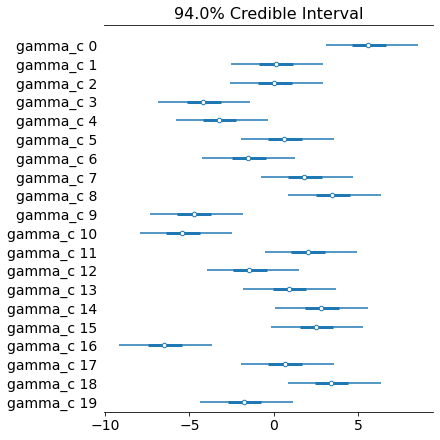

In [44]:
az.plot_forest(az_model4, var_names=["gamma_c"], combined=True)
plt.show()

In [45]:
post_alpha_g = model4_trace.get_values(varname="alpha_g")
post_gamma_c = model4_trace.get_values(varname="gamma_c")
post_beta_g = model4_trace.get_values(varname="beta_g")
post_mu_gc = model4_trace.get_values(varname="mu_gc")

post_mu_mean = post_mu_gc.mean(axis=0)
post_mu_hdi = np.array([az.hpd(x, credible_interval=0.89) for x in post_mu_gc.T])

logfc_post_df = logfc_data.copy()
logfc_post_df["post_logfc"] = post_mu_mean
logfc_post_df["hpi_lower"] = [x[0] for x in post_mu_hdi]
logfc_post_df["hpi_upper"] = [x[1] for x in post_mu_hdi]
logfc_post_df

gene cell_line       rna  sgrna_idx     logfc  post_logfc  hpi_lower  \
0    geneA     cellA -1.187443          0  7.516370    7.545814   7.385208   
1    geneA     cellB  0.299138          0 -1.184598   -1.734407  -1.879499   
2    geneA     cellC -0.947764          0  1.945419    1.383456   1.236099   
3    geneA     cellD -1.843382          0 -0.861100   -0.549977  -0.725759   
4    geneA     cellE  0.810589          0 -6.491923   -6.394692  -6.552350   
..     ...       ...       ...        ...       ...         ...        ...   
295  geneE     cellP  1.219362          2  0.194254    0.129988  -0.028267   
296  geneE     cellQ -0.840481          2 -5.967522   -6.197975  -6.347947   
297  geneE     cellR  0.607882          2 -0.719954   -0.913733  -1.062864   
298  geneE     cellS  0.429605          2  1.885927    2.056609   1.913436   
299  geneE     cellT -1.014537          2 -1.022285   -1.254635  -1.408618   

     hpi_upper  
0     7.700742  
1    -1.597755  
2     1.532617  
3    -0.381140  
4    -6.256804  
..         ...  
295   0.281621  
296  -6.051232  
297  -0.764337  
298   2.197181  
299  -1.093348  

[300 rows x 8 columns]

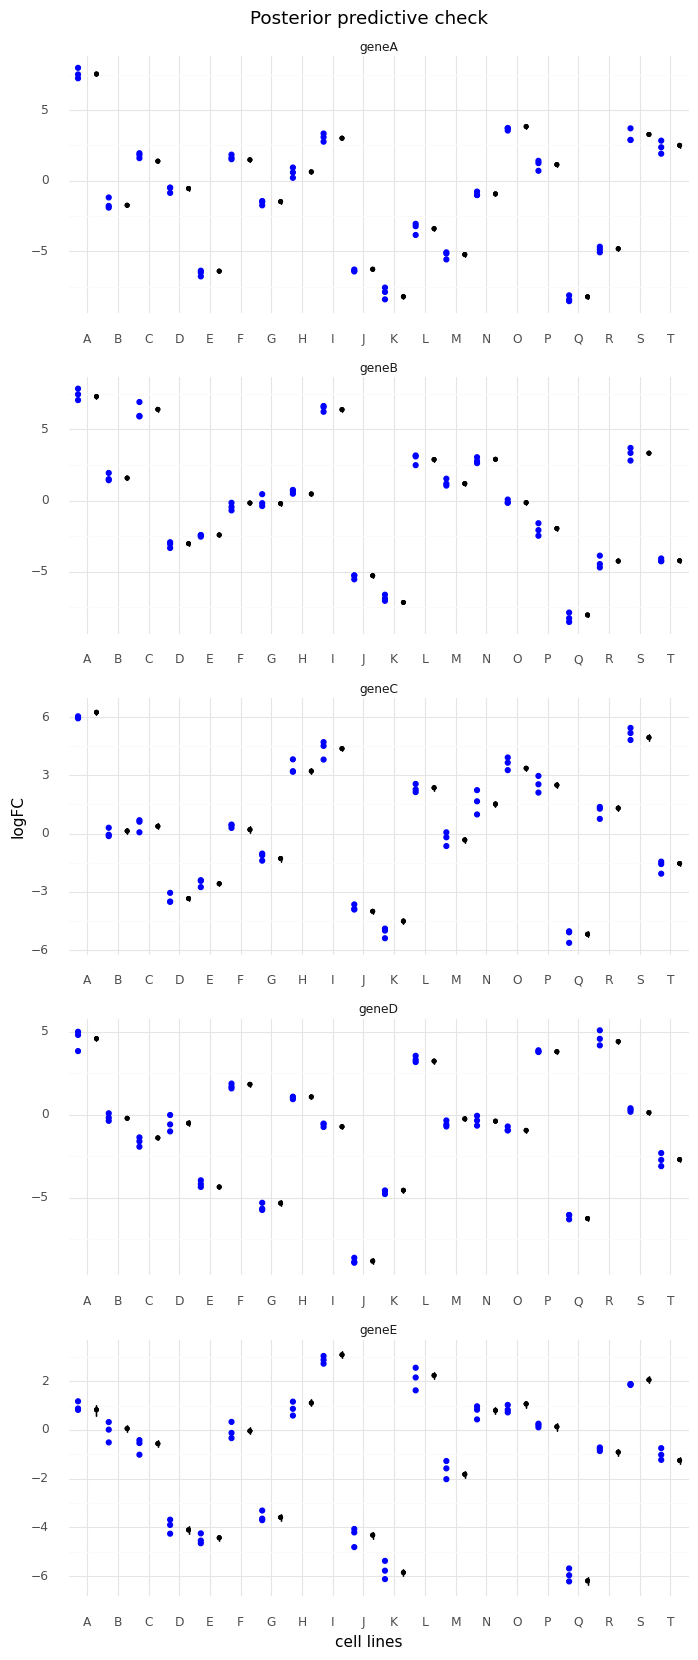

<ggplot: (8786093598154)>

In [46]:
(
    gg.ggplot(logfc_post_df, gg.aes(x="cell_line"))
    + gg.facet_wrap("gene", ncol=1, scales="free")
    + gg.geom_linerange(
        gg.aes(ymin="hpi_lower", ymax="hpi_upper"), position=gg.position_nudge(x=0.3)
    )
    + gg.geom_point(gg.aes(y="post_logfc"), position=gg.position_nudge(x=0.3), size=1)
    + gg.geom_point(gg.aes(y="logfc"), position=gg.position_nudge(x=-0.3), color="blue")
    + gg.scale_x_discrete(labels=[a.replace("cell", "") for a in cell_lines])
    + gg.theme(subplots_adjust={"hspace": 0.25, "wspace": 0.25}, figure_size=(8, 20))
    + gg.labs(x="cell lines", y="logFC", title="Posterior predictive check")
)

---

## Model 5. Move the varying gene intercept into a higher level

Model the logFC for knocking-out a gene $g$ in cell line $c$ with sgRNA $s$.
Use a varying intercept for the sgRNA and cell line.
Include the target gene as a varying intercept for the level of the intercept for the sgRNA.

$
logFC_{s,g,c} \sim \mathcal{N}(\mu_{s,g,c}, \sigma) \\
\quad \mu_{s,g,c} = \alpha_s + \beta_c \\
\qquad \alpha_s \sim \mathcal{N}(\mu_\alpha, \sigma_\alpha) \\
\qquad \quad \mu_\alpha = \epsilon_g \\
\qquad \qquad \epsilon_g \sim \mathcal{N}(\mu_\epsilon, \sigma_\epsilon) \\
\qquad \qquad \quad \mu_\epsilon \sim \mathcal{N}(0, 5) \quad \sigma_\epsilon \sim \text{Exp(1)} \\
\qquad \quad \sigma_\alpha \sim \text{Exp}(1) \\
\qquad \beta_c \sim \mathcal{N}(\mu_\beta, \sigma_\beta) \\
\qquad \quad \mu_\beta \sim \mathcal{N}(0, 5) \quad \sigma_\beta \sim \text{Exp}(1) \\
\quad \sigma \sim \text{Exp}(1)
$

Simulated values:

- number of cell lines: 20
- number of genes: 5
- number of repeated measures: 4
- $\mu_\epsilon = -1$, $\sigma_\epsilon = 1$
- $\sigma_\alpha = 0.1$
- $\mu_\beta = 0$, $\sigma_\beta = 1$
- $\sigma = 0.05$

In [180]:
np.random.seed(RANDOM_SEED)

# Data parameters.
num_cell_lines = 20
num_genes = 5
num_sgrna_per_gene = list(range(1, num_genes + 1))  # Different number of guides.
num_sgRNA = sum(num_sgrna_per_gene)

# Model parameters.
real_params = {
    "mu_epsilon": -1,
    "sigma_epsilon": 1,
    "sigma_alpha": 0.1,
    "mu_beta": 0,
    "sigma_beta": 1,
    "sigma": 0.05,
}

real_params["epsilon_g"] = normal(
    real_params["mu_epsilon"], real_params["sigma_epsilon"], num_genes
)

real_params["mu_alpha"] = real_params["epsilon_g"]

real_alpha_s = []
for gene_idx, n in enumerate(num_sgrna_per_gene):
    a_s = normal(real_params["mu_alpha"][gene_idx], real_params["sigma_alpha"], n)
    real_alpha_s.append(a_s)

real_params["alpha_s"] = np.concatenate(real_alpha_s)

real_params["beta_c"] = normal(
    real_params["mu_beta"], real_params["sigma_beta"], num_cell_lines
)


def alphabet_list(n, prefix=""):
    if n > len(string.ascii_uppercase):
        raise Exception(f"Max number of values is {len(string.ascii_uppercase)}")
    return [prefix + a for a in string.ascii_uppercase[:n]]


def make_cat(df, col, categories=None, ordered=None):
    df[col] = pd.Categorical(df[col], categories=categories)
    return df


# cell_lines = alphabet_list(num_cell_lines, "cell_")
cell_lines = ["cell_" + str(i) for i in range(num_cell_lines)]
genes = alphabet_list(num_genes, "gene_")
guides = ["sgRNA_" + str(i) for i in range(sum(num_sgrna_per_gene))]

alpha_s_table = pd.DataFrame(
    {
        "gene": np.repeat(genes, num_sgrna_per_gene),
        "sgRNA": guides,
        "alpha_s": real_params["alpha_s"],
    }
)

for col, vals in zip(["gene", "sgRNA"], [genes, guides]):
    alpha_s_table = make_cat(alpha_s_table, col, categories=vals)

data = pd.DataFrame(
    product(genes, cell_lines), columns=["gene", "cell_line"], dtype="category"
)
data = pd.merge(data, alpha_s_table[["gene", "sgRNA"]], how="right", on="gene")
data = data.reset_index(drop=True)

for col, vals in zip(["cell_line", "gene", "sgRNA"], [cell_lines, genes, guides]):
    data = make_cat(data, col, categories=vals)

data["logfc"] = np.nan
for i in range(len(data)):
    s = data["sgRNA"].cat.codes[i]
    c = data["cell_line"].cat.codes[i]
    logfc = normal(
        real_params["alpha_s"][s] + real_params["beta_c"][c], real_params["sigma"]
    )
    data.loc[i, "logfc"] = logfc

data.head(10)

gene cell_line    sgRNA     logfc
0  gene_A    cell_0  sgRNA_0 -0.699825
1  gene_A    cell_1  sgRNA_0 -3.689952
2  gene_A    cell_2  sgRNA_0 -1.349566
3  gene_A    cell_3  sgRNA_0 -0.485567
4  gene_A    cell_4  sgRNA_0 -2.253759
5  gene_A    cell_5  sgRNA_0 -2.828712
6  gene_A    cell_6  sgRNA_0 -2.950248
7  gene_A    cell_7  sgRNA_0 -1.710152
8  gene_A    cell_8  sgRNA_0 -2.636155
9  gene_A    cell_9  sgRNA_0 -2.274055

In [181]:
print(real_params["epsilon_g"])
print(real_params["alpha_s"])
print(real_params["beta_c"])

[-2.24927835 -1.26033141 -0.6162067  -1.38546147 -2.08513673]
[-2.01655645 -1.21725212 -1.21709984 -0.71420783 -0.67940322 -0.55846249
 -1.39793725 -1.28756669 -1.22596932 -1.50565593 -2.22277361 -1.97970218
 -2.08902208 -2.01710816 -1.95221924]
[ 1.28344952 -1.75825367  0.6143059   1.51635808 -0.19597741 -0.81720628
 -0.94612771  0.22063891 -0.60073351 -0.15256605 -1.18744311  0.29913821
 -0.94776417 -1.84338194  0.81058919 -0.75225658 -0.43646901  0.04727664
 -0.25082764  0.16708739]


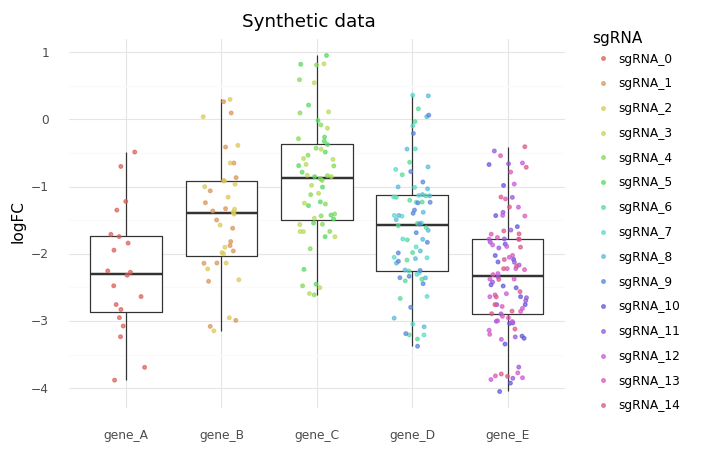

<ggplot: (8786074975645)>

In [182]:
(
    gg.ggplot(data, gg.aes(x="gene", y="logfc"))
    + gg.geom_boxplot(outlier_color="")
    + gg.geom_jitter(gg.aes(color="sgRNA"), width=0.2, height=0, size=1, alpha=0.7)
    + gg.scale_color_discrete()
    + gg.labs(x="", y="logFC", title="Synthetic data")
)

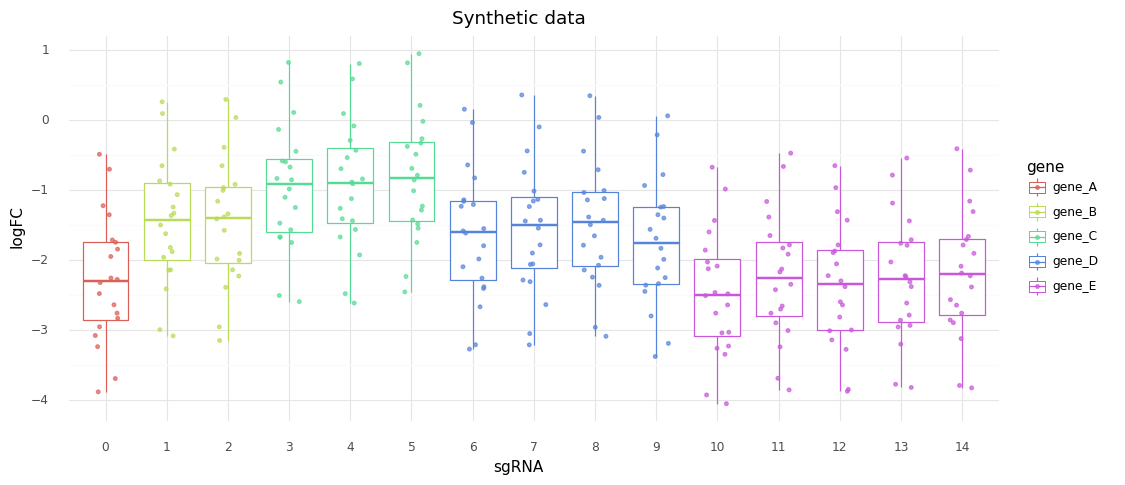

<ggplot: (8786075168937)>

In [183]:
(
    gg.ggplot(data, gg.aes(x="sgRNA", y="logfc"))
    + gg.geom_boxplot(gg.aes(color="gene"), outlier_color="")
    + gg.geom_jitter(gg.aes(color="gene"), width=0.2, height=0, size=1, alpha=0.7)
    + gg.scale_color_discrete()
    + gg.scale_x_discrete(labels=[a.replace("sgRNA_", "") for a in guides])
    + gg.theme(figure_size=(12, 5))
    + gg.labs(x="sgRNA", y="logFC", title="Synthetic data")
)

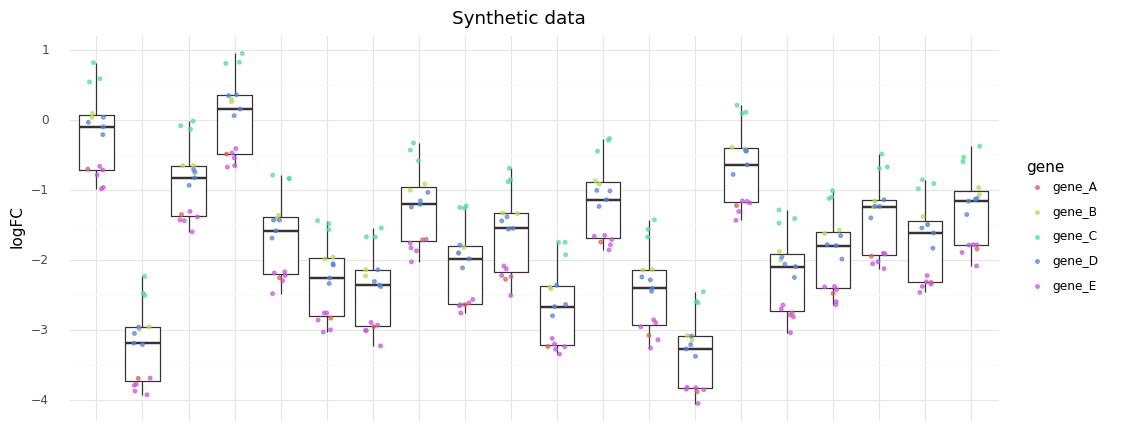

<ggplot: (8786075996344)>

In [184]:
(
    gg.ggplot(data, gg.aes(x="cell_line", y="logfc"))
    + gg.geom_boxplot(outlier_color="")
    + gg.geom_jitter(gg.aes(color="gene"), width=0.2, height=0, size=1, alpha=0.7)
    + gg.scale_color_discrete()
    + gg.theme(figure_size=(12, 5), axis_text_x=gg.element_blank())
    + gg.labs(x="", y="logFC", title="Synthetic data")
)

In [185]:
# Data with the cell line effect removed.
rm_cell_line_effect = []
for i in range(len(data)):
    c_idx = data["cell_line"].cat.codes[i]
    c_eff = real_params["beta_c"][c_idx]
    rm_cell_line_effect.append(data["logfc"].values[i] - c_eff)

mod_data = data.copy()
mod_data["logfc_no_cell"] = rm_cell_line_effect

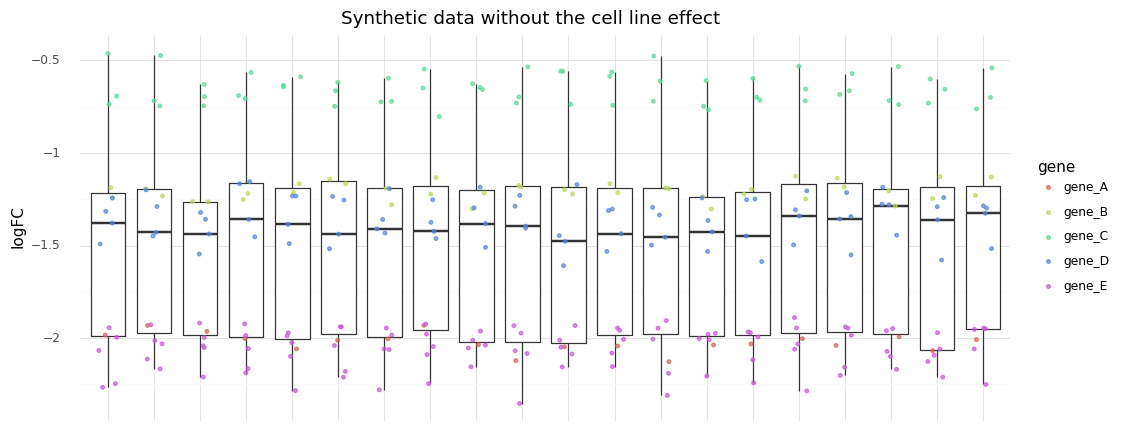

<ggplot: (8786074933520)>

In [186]:
(
    gg.ggplot(mod_data, gg.aes(x="cell_line", y="logfc_no_cell"))
    + gg.geom_boxplot(outlier_color="")
    + gg.geom_jitter(gg.aes(color="gene"), width=0.2, height=0, size=1, alpha=0.7)
    + gg.scale_color_discrete()
    + gg.theme(figure_size=(12, 5), axis_text_x=gg.element_blank())
    + gg.labs(x="", y="logFC", title="Synthetic data without the cell line effect")
)

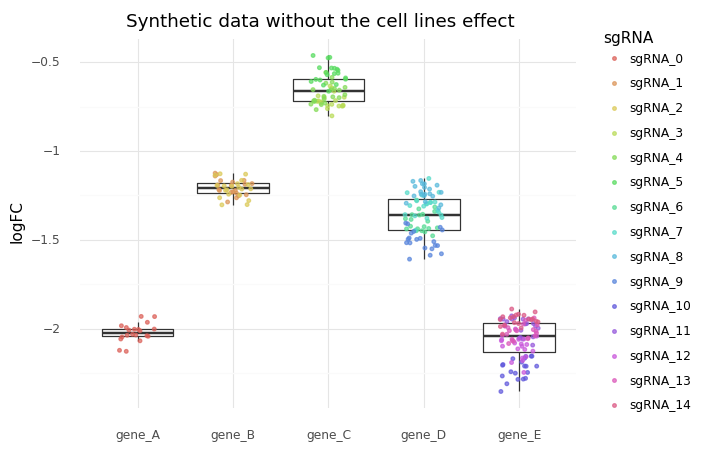

<ggplot: (8786089864674)>

In [187]:
(
    gg.ggplot(mod_data, gg.aes(x="gene", y="logfc_no_cell"))
    + gg.geom_boxplot(outlier_color="")
    + gg.geom_jitter(gg.aes(color="sgRNA"), width=0.2, height=0, size=1, alpha=0.7)
    + gg.scale_color_discrete()
    + gg.labs(x="", y="logFC", title="Synthetic data without the cell lines effect")
)

In [202]:
cell_line_idx = data["cell_line"].cat.codes.to_list()
sgrna_idx = data["sgRNA"].cat.codes.to_list()
sgrna_to_gene_idx = (
    data[["gene", "sgRNA"]].drop_duplicates()["gene"].cat.codes.to_list()
)

with pm.Model() as model5_2:
    # Gene level model
    mu_epsilon = pm.Normal("mu_epsilon", -1, 5)
    sigma_epsilon = pm.Exponential("sigma_epsilon", 1)
    epsilon_g = pm.Normal("epsilon_g", mu_epsilon, sigma_epsilon, shape=num_genes)

    # Guide level model
    mu_alpha = pm.Deterministic("mu_alpha", epsilon_g[sgrna_to_gene_idx])
    sigma_alpha = pm.Exponential("sigma_alpha", 1)
    alpha_s = pm.Normal("alpha_s", mu_alpha, sigma_alpha, shape=num_sgRNA)

    # Cell line level
    mu_beta = pm.Normal("mu_beta", 0, 3)
    sigma_beta = pm.Exponential("sigma_beta", 1)
    beta_c = pm.Normal("beta_c", mu_beta, sigma_beta, shape=num_cell_lines)

    # Likelihood
    mu_sgc = pm.Deterministic("mu_sgc", alpha_s[sgrna_idx] + beta_c[cell_line_idx])
    sigma = pm.Exponential("sigma", 1)
    logfc = pm.Normal("logfc", mu_sgc, sigma, observed=data["logfc"].values)

    # Sampling
    model5_2_prior_check = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    model5_2_trace = pm.sample(4000, tune=1000, random_seed=RANDOM_SEED)
    model5_2_post_check = pm.sample_posterior_predictive(
        model5_2_trace, random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_c, sigma_beta, mu_beta, alpha_s, sigma_alpha, epsilon_g, sigma_epsilon, mu_epsilon]
Sampling 4 chains, 0 divergences: 100%|██████████| 20000/20000 [09:17<00:00, 35.84draws/s]
The acceptance probability does not match the target. It is 0.4521039247142773, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.5648190750032425, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.6798292932488531, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reach

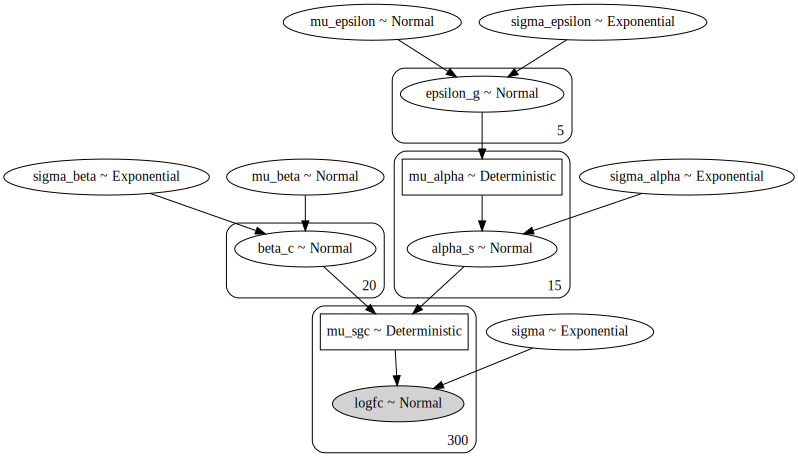

In [203]:
pm.model_to_graphviz(model5_2)

In [204]:
def plot_variable_prior(var):
    prior_df = model5_2_prior_check[var]
    prior_df = pd.DataFrame(
        prior_df, columns=[f"{var}[" + str(i) + "]" for i in range(prior_df.shape[1])],
    ).melt()

    return (
        gg.ggplot(prior_df, gg.aes(x="value"))
        + gg.geom_density(gg.aes(color="variable"))
        + gg.labs(title=f"Prior distribution for '{var}' in model 5")
    )

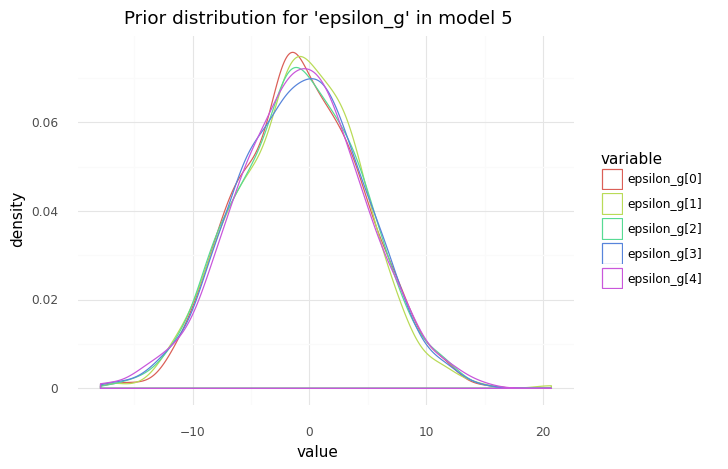

<ggplot: (8786073119455)>

In [205]:
plot_variable_prior("epsilon_g")

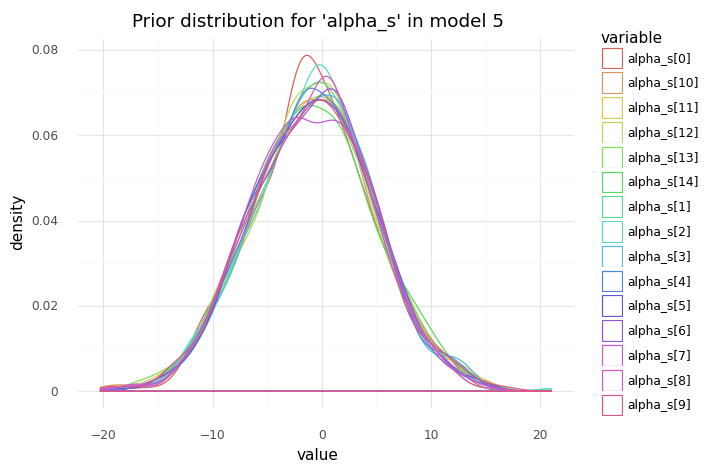

<ggplot: (8786067757915)>

In [206]:
plot_variable_prior("alpha_s")

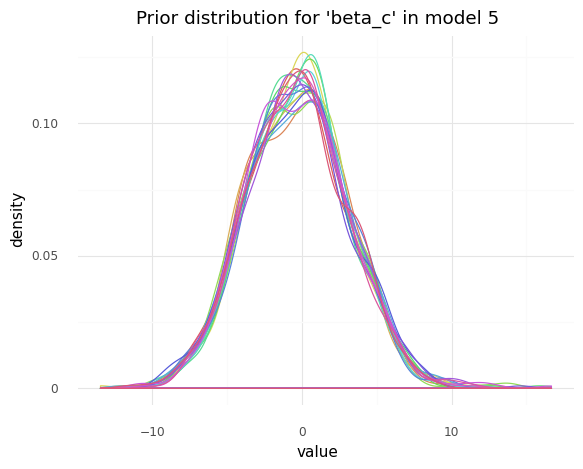

<ggplot: (8786073092175)>

In [207]:
plot_variable_prior("beta_c") + gg.theme(legend_position="none")

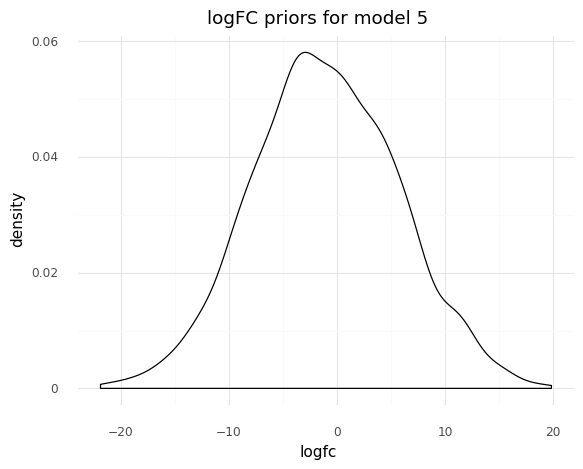

<ggplot: (8786075340683)>

In [208]:
logfc_priors = pd.DataFrame({"logfc": model5_2_prior_check["logfc"].flatten()[::100]})

(
    gg.ggplot(logfc_priors, gg.aes(x="logfc"))
    + gg.geom_density()
    + gg.labs(title="logFC priors for model 5")
)

In [209]:
az_model5_2 = az.from_pymc3(
    trace=model5_2_trace,
    prior=model5_2_prior_check,
    posterior_predictive=model5_2_post_check,
    model=model5_2,
)

In [210]:
az.summary(az_model5_2, var_names=["mu_epsilon"]).assign(
    real_values=real_params["mu_epsilon"]
)

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
mu_epsilon -1.833  2.553  -6.597    2.985      0.176    0.124     211.0   

            ess_sd  ess_bulk  ess_tail  r_hat  real_values  
mu_epsilon   211.0     212.0     392.0   1.04           -1

In [211]:
az.summary(az_model5_2, var_names=["epsilon_g"]).assign(
    real_values=real_params["epsilon_g"]
)

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
epsilon_g[0] -2.378  2.541  -7.306    2.223      0.176    0.124     210.0   
epsilon_g[1] -1.589  2.538  -6.200    3.310      0.175    0.124     210.0   
epsilon_g[2] -1.041  2.538  -5.648    3.854      0.175    0.124     209.0   
epsilon_g[3] -1.739  2.537  -6.519    2.995      0.175    0.124     209.0   
epsilon_g[4] -2.430  2.537  -7.322    2.202      0.175    0.124     209.0   

              ess_sd  ess_bulk  ess_tail  r_hat  real_values  
epsilon_g[0]   210.0     210.0     380.0   1.04    -2.249278  
epsilon_g[1]   210.0     211.0     381.0   1.04    -1.260331  
epsilon_g[2]   209.0     210.0     375.0   1.04    -0.616207  
epsilon_g[3]   209.0     210.0     378.0   1.04    -1.385461  
epsilon_g[4]   209.0     210.0     376.0   1.04    -2.085137

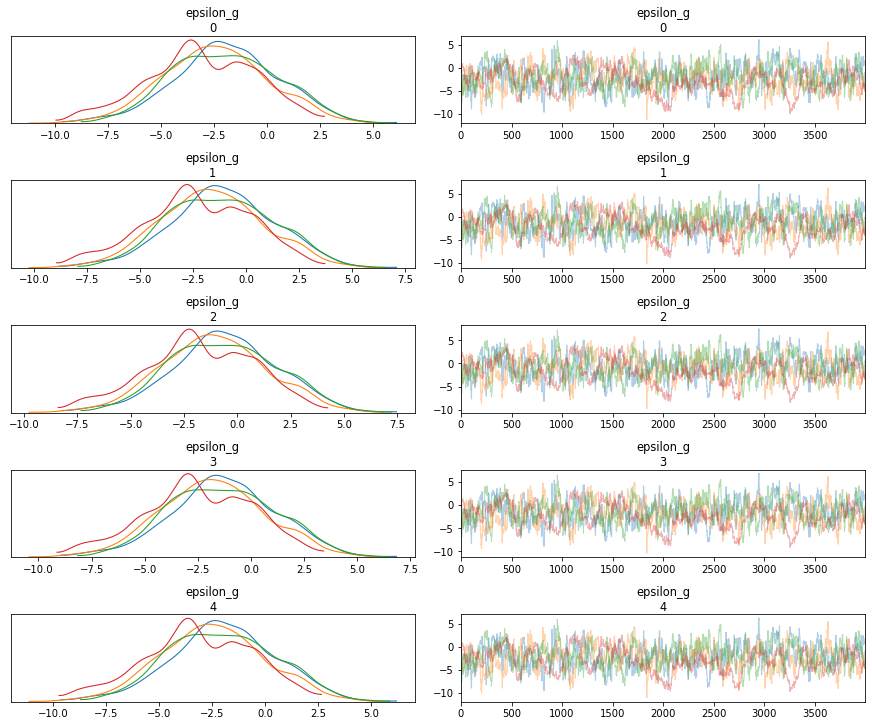

In [212]:
az.plot_trace(az_model5_2, var_names=["epsilon_g"])
plt.show()

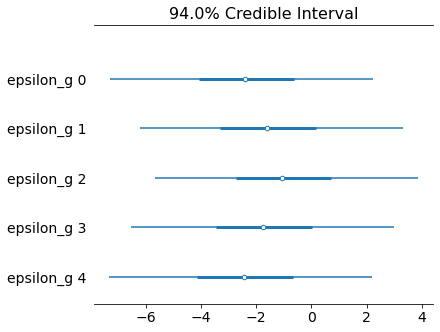

In [213]:
az.plot_forest(az_model5_2, var_names=["epsilon_g"], combined=True)
plt.show()

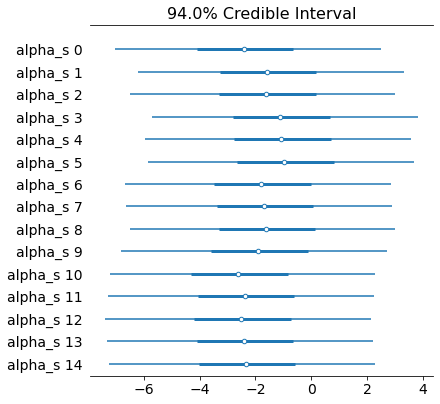

In [214]:
az.plot_forest(az_model5_2, var_names=["alpha_s"], combined=True)
plt.show()

array([<AxesSubplot:title={'center':'94.0% Credible Interval'}>],
      dtype=object)

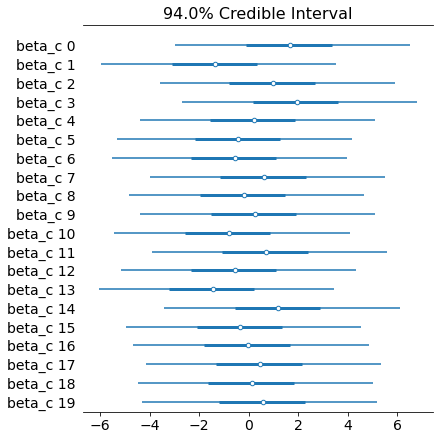

In [215]:
az.plot_forest(az_model5_2, var_names="beta_c", combined=True)

In [383]:
np.random.seed(RANDOM_SEED)

# Data parameters.
num_cell_lines = 20
num_genes = 5
num_sgrna_per_gene = list(range(1, num_genes + 1))  # Different number of guides.
num_sgRNA = sum(num_sgrna_per_gene)

# Model parameters.
real_params = {
    "mu_beta": 0,
    "sigma_beta": 1,
    "sigma": 0.5,
    "alpha_s": [
        -0.4,
        -0.2,
        -0.3,
        0,
        -0.5,
        -0.6,
        -1,
        -1.2,
        -1.7,
        -0.8,
        2,
        1.7,
        2.4,
        2.1,
        0,
    ],
}

real_params["beta_c"] = normal(
    real_params["mu_beta"], real_params["sigma_beta"], num_cell_lines
)

# Check to make sure therre are enough values.
if len(real_params["alpha_s"]) != sum(num_sgrna_per_gene):
    raise Exception(
        f"Incorrect number of values for `alpha_s`: have {len(real_params['alpha_s'])}; need {sum(num_sgrna_per_gene)}"
    )


def alphabet_list(n, prefix=""):
    if n > len(string.ascii_uppercase):
        raise Exception(f"Max number of values is {len(string.ascii_uppercase)}")
    return [prefix + a for a in string.ascii_uppercase[:n]]


def make_cat(df, col, categories=None, ordered=None):
    df[col] = pd.Categorical(df[col], categories=categories)
    return df


cell_lines = alphabet_list(num_cell_lines, "cell")
genes = alphabet_list(num_genes, "gene")
guides = ["sgRNA_" + str(i) for i in range(sum(num_sgrna_per_gene))]

alpha_s_table = pd.DataFrame(
    {
        "gene": np.repeat(genes, num_sgrna_per_gene),
        "sgRNA": guides,
        "alpha_s": real_params["alpha_s"],
    }
)
alpha_s_table = make_cat(alpha_s_table, "gene", categories=genes)
alpha_s_table = make_cat(alpha_s_table, "sgRNA", categories=guides)

data = pd.DataFrame(
    product(genes, cell_lines), columns=["gene", "cell_line"], dtype="category"
)
data = pd.merge(data, alpha_s_table[["gene", "sgRNA"]], how="right", on="gene")
data = data.reset_index(drop=True)
data = make_cat(data, "cell_line", categories=cell_lines)
data = make_cat(data, "gene", categories=genes)
data = make_cat(data, "sgRNA", categories=guides)

data["logfc"] = np.nan
for i in range(len(data)):
    s = data["sgRNA"].cat.codes[i]
    c = data["cell_line"].cat.codes[i]
    logfc = normal(
        real_params["alpha_s"][s] + real_params["beta_c"][c], real_params["sigma"]
    )
    data.loc[i, "logfc"] = logfc

data.head(10)

gene cell_line    sgRNA     logfc
0  geneA     cellA  sgRNA_0 -1.007554
1  geneA     cellB  sgRNA_0 -1.539458
2  geneA     cellC  sgRNA_0  0.290946
3  geneA     cellD  sgRNA_0 -0.027282
4  geneA     cellE  sgRNA_0 -1.583125
5  geneA     cellF  sgRNA_0  1.518616
6  geneA     cellG  sgRNA_0 -0.442271
7  geneA     cellH  sgRNA_0  0.142635
8  geneA     cellI  sgRNA_0 -1.680378
9  geneA     cellJ  sgRNA_0 -1.108248

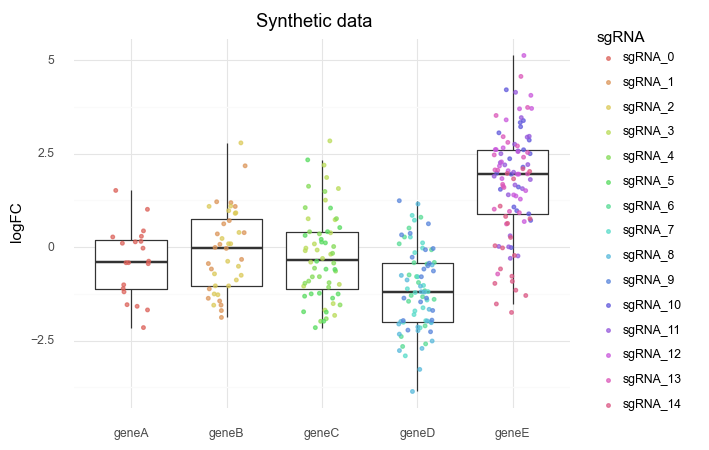

<ggplot: (8779171864173)>

In [384]:
(
    gg.ggplot(data, gg.aes(x="gene", y="logfc"))
    + gg.geom_boxplot(outlier_color="")
    + gg.geom_jitter(gg.aes(color="sgRNA"), width=0.2, size=1, alpha=0.7)
    + gg.scale_color_discrete()
    + gg.labs(x="", y="logFC", title="Synthetic data")
)

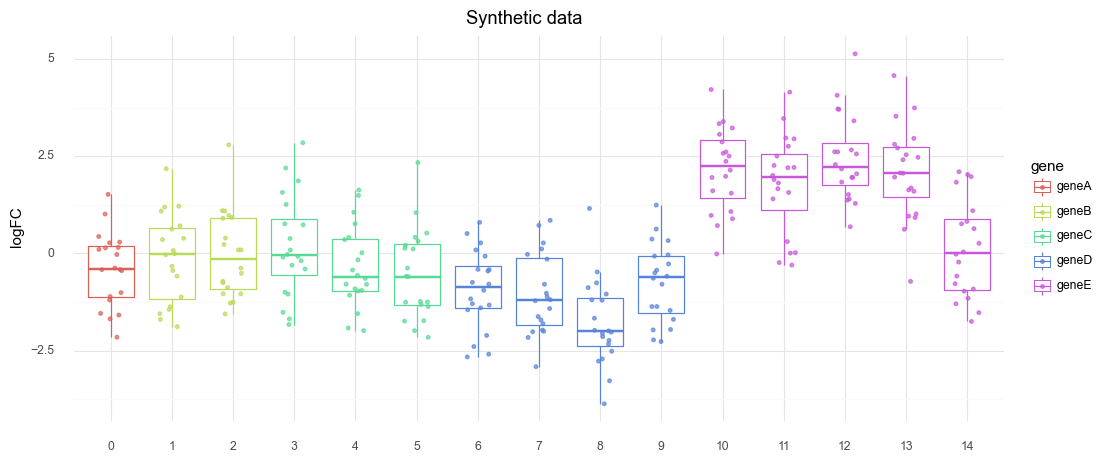

<ggplot: (8779105775297)>

In [385]:
(
    gg.ggplot(data, gg.aes(x="sgRNA", y="logfc"))
    + gg.geom_boxplot(gg.aes(color="gene"), outlier_color="")
    + gg.geom_jitter(gg.aes(color="gene"), width=0.2, size=1, alpha=0.7)
    + gg.scale_color_discrete()
    + gg.scale_x_discrete(labels=[a.replace("sgRNA_", "") for a in guides])
    + gg.theme(figure_size=(12, 5))
    + gg.labs(x="", y="logFC", title="Synthetic data")
)

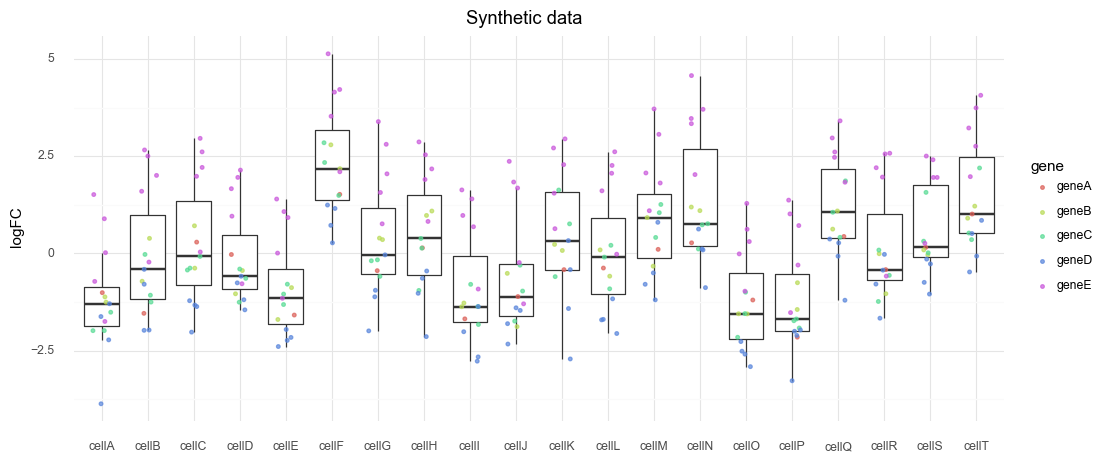

<ggplot: (8779102786933)>

In [386]:
(
    gg.ggplot(data, gg.aes(x="cell_line", y="logfc"))
    + gg.geom_boxplot(outlier_color="")
    + gg.geom_jitter(gg.aes(color="gene"), width=0.2, size=1, alpha=0.7)
    + gg.scale_color_discrete()
    + gg.theme(figure_size=(12, 5))
    + gg.labs(x="", y="logFC", title="Synthetic data")
)

This model samples very slowly and only gets a few effective samples (~200) for some of the higher-level parameters.
Taking more samples fixes this problem, but for experimental purposes, the posterior distributions are actually quite accurate (i.e. taking more samples adds more effective samples for the higher-level parameters, but doesn't really change the shape of the posteriors).

In [292]:
sgrna_idx = data["sgRNA"].cat.codes.to_list()
gene_idx = data["gene"].cat.codes.to_list()
cell_line_idx = data["cell_line"].cat.codes.to_list()

sgrna_to_gene_idx = alpha_s_table["gene"].cat.codes.to_list()

with pm.Model() as model5:
    # Hyper-priors
    mu_epsilon = pm.Normal("mu_epsilon", 0, 5)
    sigma_epsilon = pm.Exponential("sigma_epsilon", 1)
    sigma_alpha = pm.Exponential("sigma_alpha", 1)
    mu_beta = pm.Normal("mu_beta", 0, 5)
    sigma_beta = pm.Exponential("sigma_beta", 1)

    # sgRNA level
    epsilon_g = pm.Normal("epsilon_g", mu_epsilon, sigma_epsilon, shape=num_genes)
    mu_alpha = epsilon_g[sgrna_to_gene_idx]

    # Main level priors
    alpha_s = pm.Normal("alpha_s", mu_alpha, sigma_alpha, shape=num_sgRNA)
    beta_c = pm.Normal("beta_c", mu_beta, sigma_beta, shape=num_cell_lines)

    # Main level
    mu_sgc = pm.Deterministic("mu_sgc", alpha_s[sgrna_idx] + beta_c[cell_line_idx])
    sigma = pm.Exponential("sigma", 1)

    # Likelihood
    logfc = pm.Normal("logfc", mu_sgc, sigma, observed=data.logfc)

    # Sampling
    model5_prior_check = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    model5_trace = pm.sample(3000, tune=2000)
    model5_post_check = pm.sample_posterior_predictive(
        model5_trace, random_seed=RANDOM_SEED
    )

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta_c, alpha_s, epsilon_g, sigma_beta, mu_beta, sigma_alpha, sigma_epsilon, mu_epsilon]
Sampling 2 chains, 3 divergences: 100%|██████████| 44000/44000 [12:20<00:00, 59.43draws/s] 
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8919250649269245, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or repar

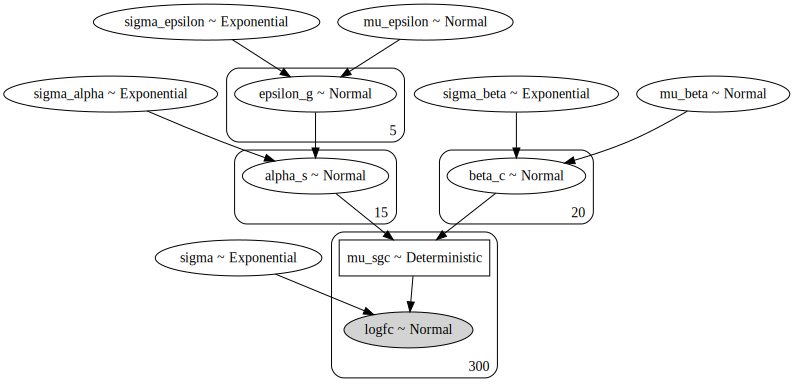

In [293]:
pm.model_to_graphviz(model5)

In [294]:
az_model5 = az.from_pymc3(
    trace=model5_trace, prior=model5_prior_check, posterior_predictive=model5_post_check
)

In [295]:
az.summary(az_model5, var_names=["alpha_s"]).assign(
    real_values=alpha_s_table["alpha_s"].values
)

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
alpha_s[0]  -0.440  3.475  -6.733    6.525      0.092    0.065    1411.0   
alpha_s[1]  -0.172  3.475  -6.443    6.817      0.092    0.065    1412.0   
alpha_s[2]  -0.084  3.475  -6.282    6.975      0.093    0.065    1411.0   
alpha_s[3]   0.121  3.474  -6.127    7.153      0.093    0.065    1411.0   
alpha_s[4]  -0.388  3.475  -6.604    6.678      0.092    0.065    1412.0   
alpha_s[5]  -0.558  3.475  -6.772    6.491      0.092    0.065    1411.0   
alpha_s[6]  -0.972  3.476  -7.254    6.031      0.093    0.065    1410.0   
alpha_s[7]  -1.099  3.474  -7.318    5.937      0.093    0.065    1411.0   
alpha_s[8]  -1.816  3.475  -8.049    5.236      0.092    0.065    1411.0   
alpha_s[9]  -0.804  3.474  -6.992    6.251      0.093    0.065    1410.0   
alpha_s[10]  2.089  3.475  -4.290    8.976      0.093    0.071    1410.0   
alpha_s[11]  1.730  3.475  -4.469    8.796      0.092    0.071    1412.0   
alpha_s[12]  2.376  3.475  -3.871    9.389      0.093    0.071    1411.0   
alpha_s[13]  2.016  3.475  -4.257    9.015      0.093    0.071    1410.0   
alpha_s[14]  0.119  3.475  -6.145    7.123      0.092    0.066    1412.0   

             ess_sd  ess_bulk  ess_tail  r_hat  real_values  
alpha_s[0]   1411.0    1415.0    1643.0    1.0         -0.4  
alpha_s[1]   1412.0    1415.0    1644.0    1.0         -0.2  
alpha_s[2]   1411.0    1414.0    1634.0    1.0         -0.3  
alpha_s[3]   1409.0    1414.0    1646.0    1.0          0.0  
alpha_s[4]   1412.0    1416.0    1634.0    1.0         -0.5  
alpha_s[5]   1411.0    1415.0    1649.0    1.0         -0.6  
alpha_s[6]   1410.0    1413.0    1652.0    1.0         -1.0  
alpha_s[7]   1411.0    1414.0    1628.0    1.0         -1.2  
alpha_s[8]   1411.0    1415.0    1659.0    1.0         -1.7  
alpha_s[9]   1410.0    1413.0    1645.0    1.0         -0.8  
alpha_s[10]  1197.0    1413.0    1646.0    1.0          2.0  
alpha_s[11]  1209.0    1415.0    1627.0    1.0          1.7  
alpha_s[12]  1193.0    1414.0    1641.0    1.0          2.4  
alpha_s[13]  1199.0    1413.0    1653.0    1.0          2.1  
alpha_s[14]  1407.0    1415.0    1647.0    1.0          0.0

In [296]:
az.summary(az_model5, var_names="sigma_beta").assign(
    real_value=real_params["sigma_beta"]
)

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
sigma_beta  1.029  0.178   0.718    1.357      0.002    0.001    8880.0   

            ess_sd  ess_bulk  ess_tail  r_hat  real_value  
sigma_beta  8756.0    9129.0   10531.0    1.0           1

In [305]:
az.summary(az_model5, var_names=["epsilon_g"]).assign(
    real_value=alpha_s_table.groupby("gene").mean().alpha_s.values
)

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
epsilon_g[0] -0.309  3.520  -7.240    6.190      0.092    0.065    1455.0   
epsilon_g[1] -0.103  3.501  -6.598    6.749      0.092    0.065    1433.0   
epsilon_g[2] -0.238  3.488  -6.708    6.620      0.092    0.065    1427.0   
epsilon_g[3] -1.033  3.486  -7.198    6.104      0.093    0.065    1419.0   
epsilon_g[4]  1.499  3.491  -5.054    8.275      0.092    0.070    1425.0   

              ess_sd  ess_bulk  ess_tail  r_hat  real_value  
epsilon_g[0]  1455.0    1457.0    1722.0    1.0   -0.400000  
epsilon_g[1]  1433.0    1435.0    1710.0    1.0   -0.250000  
epsilon_g[2]  1427.0    1430.0    1663.0    1.0   -0.366667  
epsilon_g[3]  1419.0    1422.0    1657.0    1.0   -1.175000  
epsilon_g[4]  1238.0    1428.0    1660.0    1.0    1.640000

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.7/site-packages/arviz/plots/

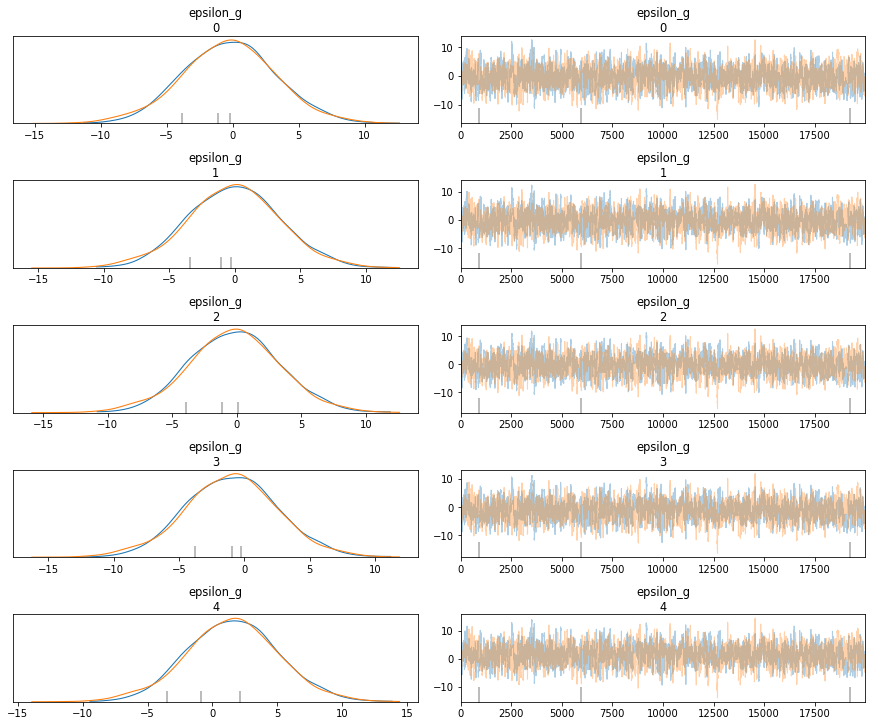

In [299]:
az.plot_trace(az_model5, var_names=["epsilon_g"])
plt.show()

In [308]:
az.summary(az_model5, var_names=["sigma_epsilon", "mu_epsilon"])

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
sigma_epsilon  1.177  0.507   0.429    2.141      0.006    0.004    7419.0   
mu_epsilon    -0.035  3.473  -6.646    6.648      0.091    0.065    1442.0   

               ess_sd  ess_bulk  ess_tail  r_hat  
sigma_epsilon  7419.0    7136.0    6557.0    1.0  
mu_epsilon     1442.0    1444.0    1727.0    1.0

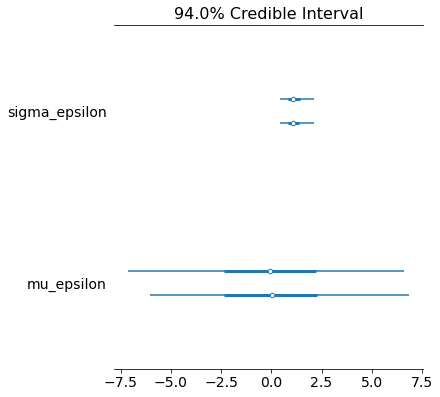

In [310]:
az.plot_forest(az_model5, var_names=["sigma_epsilon", "mu_epsilon"])
plt.show()

In [312]:
az.summary(az_model5, var_names=["beta_c"]).assign(real_value=real_params["beta_c"])

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
beta_c[0]  -1.309  3.475  -8.332    4.937      0.093    0.070    1411.0   
beta_c[1]  -0.191  3.476  -7.247    6.044      0.092    0.066    1412.0   
beta_c[2]   0.099  3.475  -6.947    6.324      0.093    0.065    1411.0   
beta_c[3]  -0.258  3.476  -7.268    6.011      0.093    0.066    1411.0   
beta_c[4]  -1.040  3.476  -8.052    5.214      0.093    0.069    1411.0   
beta_c[5]   2.198  3.476  -4.839    8.452      0.093    0.065    1410.0   
beta_c[6]   0.244  3.476  -6.590    6.685      0.093    0.065    1412.0   
beta_c[7]   0.374  3.475  -6.467    6.798      0.093    0.065    1411.0   
beta_c[8]  -1.010  3.476  -7.980    5.289      0.093    0.069    1411.0   
beta_c[9]  -0.735  3.476  -7.757    5.500      0.093    0.068    1411.0   
beta_c[10]  0.359  3.477  -6.556    6.725      0.093    0.065    1411.0   
beta_c[11] -0.123  3.476  -7.149    6.118      0.092    0.065    1412.0   
beta_c[12]  0.745  3.476  -6.100    7.176      0.093    0.065    1412.0   
beta_c[13]  1.252  3.476  -5.754    7.511      0.093    0.065    1411.0   
beta_c[14] -1.319  3.476  -8.300    4.960      0.093    0.070    1412.0   
beta_c[15] -1.298  3.476  -8.320    4.955      0.093    0.070    1412.0   
beta_c[16]  1.049  3.476  -5.844    7.435      0.093    0.065    1411.0   
beta_c[17]  0.035  3.475  -6.671    6.615      0.093    0.065    1411.0   
beta_c[18]  0.451  3.476  -6.498    6.774      0.093    0.065    1412.0   
beta_c[19]  1.353  3.476  -5.746    7.515      0.092    0.065    1412.0   

            ess_sd  ess_bulk  ess_tail  r_hat  real_value  
beta_c[0]   1232.0    1414.0    1643.0    1.0   -1.249278  
beta_c[1]   1397.0    1416.0    1649.0    1.0   -0.260331  
beta_c[2]   1411.0    1414.0    1637.0    1.0    0.383793  
beta_c[3]   1383.0    1414.0    1643.0    1.0   -0.385461  
beta_c[4]   1259.0    1414.0    1640.0    1.0   -1.085137  
beta_c[5]   1410.0    1413.0    1638.0    1.0    2.327219  
beta_c[6]   1412.0    1415.0    1642.0    1.0    0.430793  
beta_c[7]   1411.0    1414.0    1634.0    1.0    0.432316  
beta_c[8]   1264.0    1414.0    1643.0    1.0   -0.980011  
beta_c[9]   1296.0    1414.0    1643.0    1.0   -0.631965  
beta_c[10]  1411.0    1414.0    1648.0    1.0    0.577442  
beta_c[11]  1412.0    1415.0    1656.0    1.0   -0.124758  
beta_c[12]  1412.0    1415.0    1639.0    1.0    0.978948  
beta_c[13]  1411.0    1414.0    1645.0    1.0    1.594922  
beta_c[14]  1231.0    1415.0    1630.0    1.0   -1.201945  
beta_c[15]  1238.0    1415.0    1647.0    1.0   -1.376369  
beta_c[16]  1411.0    1414.0    1647.0    1.0    1.054346  
beta_c[17]  1411.0    1414.0    1629.0    1.0   -0.038853  
beta_c[18]  1412.0    1415.0    1646.0    1.0    0.680286  
beta_c[19]  1412.0    1415.0    1641.0    1.0    1.329175

In [313]:
az.summary(az_model5, var_names=["mu_beta", "sigma_beta"])

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
mu_beta     0.045  3.474  -6.700    6.575      0.092    0.065    1415.0   
sigma_beta  1.029  0.178   0.718    1.357      0.002    0.001    8880.0   

            ess_sd  ess_bulk  ess_tail  r_hat  
mu_beta     1415.0    1418.0    1659.0    1.0  
sigma_beta  8756.0    9129.0   10531.0    1.0

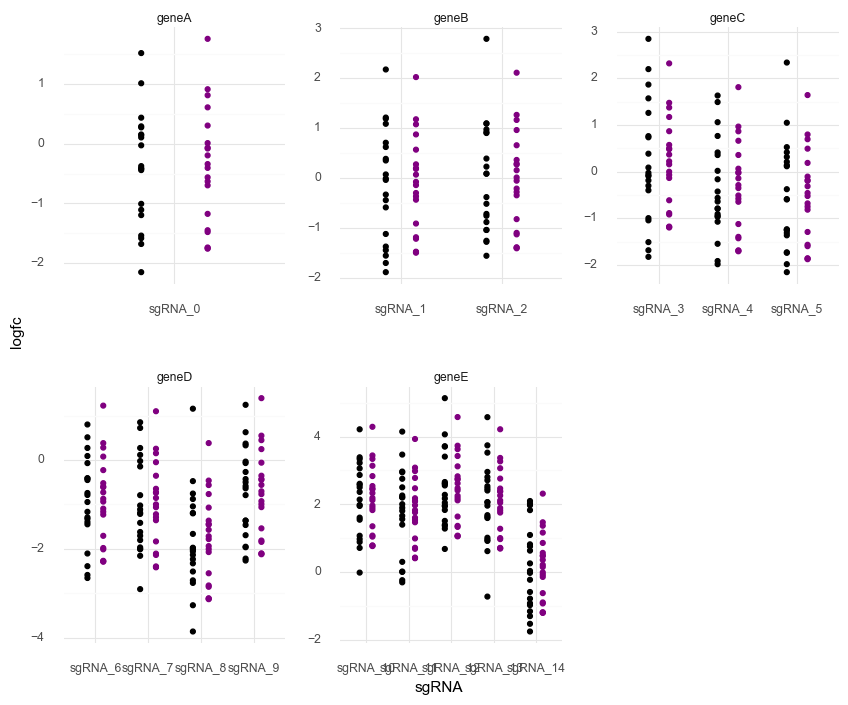

<ggplot: (8779032827969)>

In [339]:
model5_mu_post = model5_trace.get_values("mu_sgc")
model5_mu_mean = model5_mu_post.mean(axis=0)
model5_mu_hdi = [az.hpd(x, credible_interval=0.89) for x in model5_mu_post.T]

model5_ppc = data.copy()
model5_ppc["mu_mean"] = model5_mu_mean
model5_ppc["lower_ci"] = [x[0] for x in model5_mu_hdi]
model5_ppc["upper_ci"] = [x[1] for x in model5_mu_hdi]

pos_shift = 0.15

(
    gg.ggplot(model5_ppc, gg.aes("sgRNA"))
    + gg.facet_wrap("gene", scales="free")
    + gg.geom_point(gg.aes(y="logfc"), position=gg.position_nudge(x=-pos_shift))
    + gg.geom_point(
        gg.aes(y="mu_mean"), position=gg.position_nudge(x=pos_shift), color="purple"
    )
    + gg.geom_linerange(
        gg.aes(ymin="lower_ci", ymax="lower_ci"),
        position=gg.position_nudge(x=pos_shift),
        color="purple",
    )
    + gg.theme(subplots_adjust={"hspace": 0.4, "wspace": 0.25}, figure_size=(10, 8))
)

### Notes on the above Model 5

The model fits well, as shown by the very tight posterior predictions of each data point.
Reassuringly, there is also visible shrinkage in the predictions.

The posterior distributions of the parameters of $\alpha_s$, $\epsilon_g$, and $\beta_c$ are *very* wide, though the mean/MAP values are very accurate.
To me, this suggests that there is a lot of correlation between the posterior values. 
This would lead to greater play in the posteriors while maintaining very high accuracy in posterior predictions.

This is proven with the following plot. 🤦🏻‍♂️

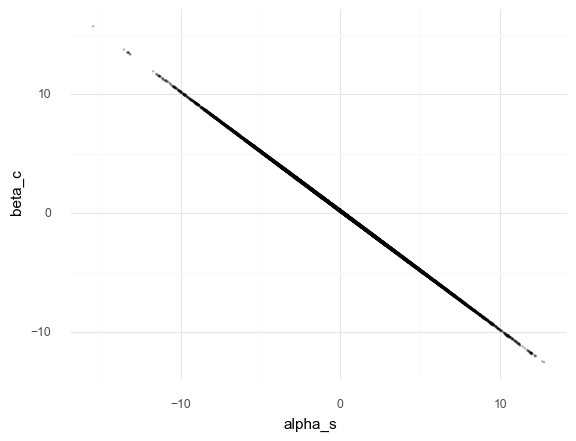

<ggplot: (8779061305961)>

In [357]:
d = pd.DataFrame(
    {
        "alpha_s": model5_trace.get_values("alpha_s").mean(axis=1),
        "beta_c": model5_trace.get_values("beta_c").mean(axis=1),
    }
)

(gg.ggplot(d, gg.aes("alpha_s", "beta_c")) + gg.geom_point(size=0.1, alpha=0.2))

In [362]:
sgrna_idx = data["sgRNA"].cat.codes.to_list()
gene_idx = data["gene"].cat.codes.to_list()
cell_line_idx = data["cell_line"].cat.codes.to_list()

with pm.Model() as model5_flat:
    # Hyper-priors
    # mu_alpha = pm.Normal("mu_epsilon", 0, 2)
    # sigma_alpha = pm.Exponential("sigma_alpha", 0.5)
    mu_beta = pm.Normal("mu_beta", 0, 2)
    sigma_beta = pm.Exponential("sigma_beta", 0.5)
    mu_gamma = pm.Normal("mu_gamma", 0, 2)
    sigma_gamma = pm.Exponential("sigma_gamma", 0.5)

    # Main level priors
    # alpha_s = pm.Normal("alpha_s", mu_alpha, sigma_alpha, shape=num_sgRNA)
    beta_c = pm.Normal("beta_c", mu_beta, sigma_beta, shape=num_cell_lines)
    gamma_g = pm.Normal("gamma_g", mu_gamma, sigma_gamma, shape=num_genes)

    # Main level
    mu_sgc = pm.Deterministic(
        "mu_sgc", beta_c[cell_line_idx] + gamma_g[gene_idx]  # + alpha_s[sgrna_idx]
    )
    sigma = pm.Exponential("sigma", 1)

    # Likelihood
    logfc = pm.Normal("logfc", mu_sgc, sigma, observed=data.logfc)

    # Sampling
    model5f_prior_check = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    model5f_trace = pm.sample(2000, tune=2000)
    model5f_post_check = pm.sample_posterior_predictive(
        model5f_trace, random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, gamma_g, beta_c, sigma_gamma, mu_gamma, sigma_beta, mu_beta]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [00:48<00:00, 164.68draws/s]
The acceptance probability does not match the target. It is 0.9020131860786756, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████| 4000/4000 [00:05<00:00, 673.71it/s]


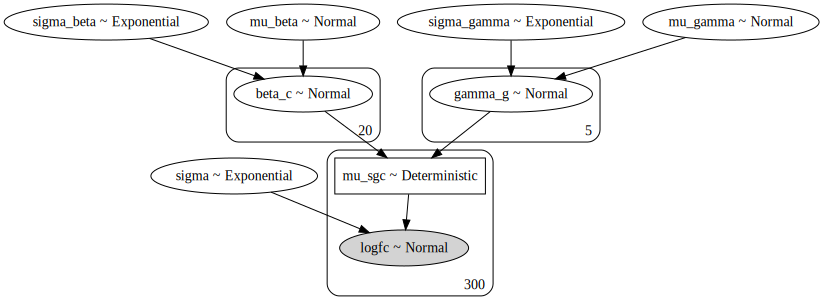

In [363]:
pm.model_to_graphviz(model5_flat)

In [364]:
az_model5f = az.from_pymc3(
    trace=model5f_trace,
    prior=model5f_prior_check,
    posterior_predictive=model5f_post_check,
)

In [366]:
az.summary(az_model5f, var_names=["gamma_g"])

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
gamma_g[0] -0.265  1.400  -2.618    2.395      0.102    0.073     187.0   
gamma_g[1]  0.040  1.390  -2.350    2.644      0.102    0.073     184.0   
gamma_g[2] -0.110  1.390  -2.504    2.491      0.102    0.072     185.0   
gamma_g[3] -1.002  1.389  -3.340    1.638      0.102    0.072     184.0   
gamma_g[4]  1.832  1.387  -0.478    4.482      0.102    0.072     184.0   

            ess_sd  ess_bulk  ess_tail  r_hat  
gamma_g[0]   187.0     185.0     307.0   1.02  
gamma_g[1]   184.0     183.0     299.0   1.02  
gamma_g[2]   185.0     184.0     302.0   1.02  
gamma_g[3]   184.0     183.0     303.0   1.02  
gamma_g[4]   184.0     183.0     306.0   1.02

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.7/site-packages/arviz/plots/

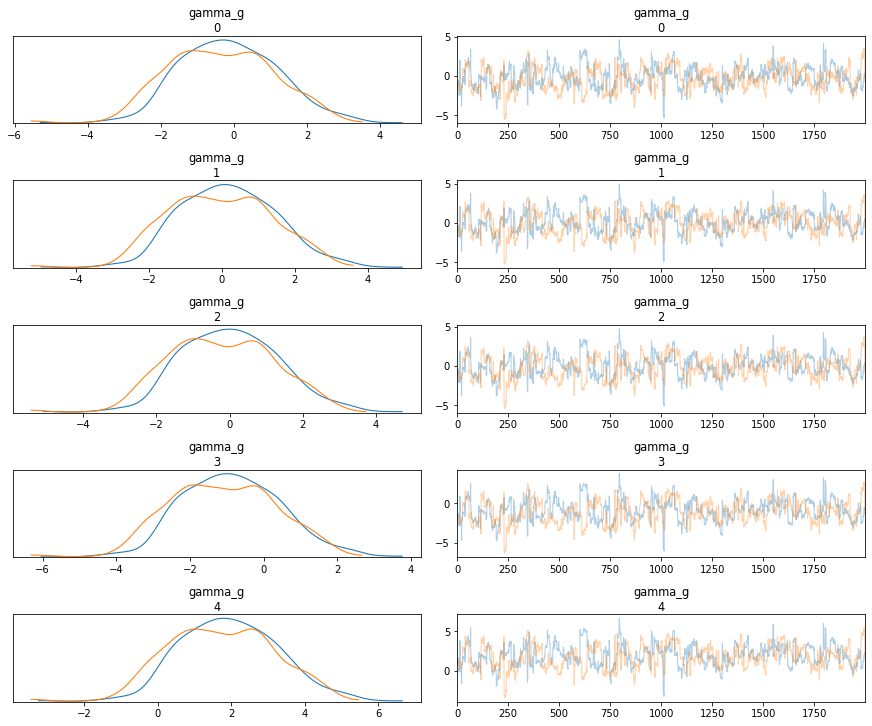

In [367]:
az.plot_trace(az_model5f, var_names="gamma_g")
plt.show()

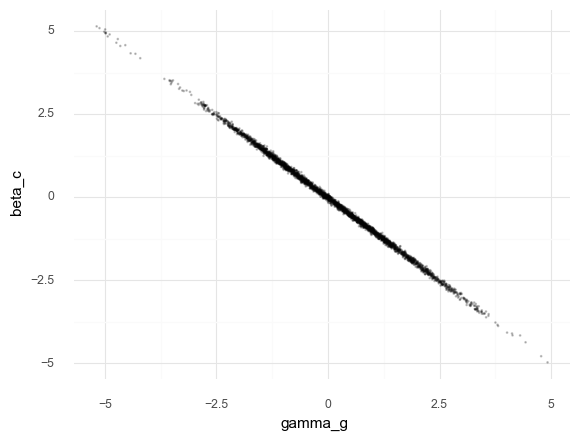

<ggplot: (8779016207877)>

In [373]:
d = pd.DataFrame(
    {
        "gamma_g": model5f_trace.get_values("gamma_g").mean(axis=1),
        "beta_c": model5f_trace.get_values("beta_c").mean(axis=1),
    }
)

(gg.ggplot(d, gg.aes("gamma_g", "beta_c")) + gg.geom_point(size=0.1, alpha=0.2))

---

### Other Models

#### Model C

- same as Model 5, but with $\sigma_{i,c}$

#### Model A

- multiple sgRNAs per gene and not all in each cell line
- varying intercept for cell line and gene; covariate with RNA in each
- copy number as a covariate at the sgRNA level

#### Model B

- Model A
- another covariate for if the gene is mutated
    - sometimes the mutation makes a difference and sometimes it doesn't
        - when it does make a difference, how much of a difference varies, too
    - is this a mixture model or varying effect? - probably a mixture model, but I'm lacking needed knowledge

---

#### General Notes

- Model where some cell lines tend to have higher RNA expression.
- Add another level for cell line varying effects corresponding to shared lineages. (To get practice with adding another level, build a model with just these effects.)